In [1]:
import graphviz 
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error

from utils import location_station, find_set_sunrise, find_set_sunset

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise_update.pkl')

In [3]:
df.columns

Index(['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2',
       'gvtec2_dt', 'state_day', 'state_night', 'state_dawn', 'vm1', 'vd1',
       'vm2', 'vd2', 'gvtec1_dt_lag_9', 'gvtec2_dt_lag_20', 'vtec_dt_lag_3',
       's4'],
      dtype='object')

In [4]:
original = ['vtec', 'vtec_dt_lag_3', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']
tempo  = ['state_day', 'state_night', 'state_dawn']
mdv1 = ['vm1', 'vd1']
mdv2 = ['vm2', 'vd2']
lag = ['gvtec1_dt_lag_9', 'gvtec2_dt_lag_20']

In [5]:
def generate_and_avaliate_model(df, instances_set, target, file_to_save_model=None, model=None):
    if not model:
        # generate model, use k-fold crossvalidation and print scores
        model = RandomForestRegressor()
        
    scaler = StandardScaler()
    scaler.fit(X=df[instances_set].values) 
    X = scaler.transform(X=df[instances_set].values)
    y = df['s4'].values
    
    size = len(X)
    last_element = size - size//10
    

    X_train, X_test, y_train, y_test = train_test_split(X[0:last_element], y[0:last_element], test_size=0.30, random_state=42)
    index = df.index.values[last_element:size+1]
                
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    # generate final model, and avaliate a test set
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    give_error(y_test, y_predict);
    print()

    # use the final model to avaliate the error in a sample of the time series
    df_aux = pd.DataFrame(index=index)
    df_aux['predito'] = model.predict(X[last_element:size+1])
    df_aux['real'] = y[last_element:size+1]

    print('Error for the time series sample:')
    give_error(df_aux['real'].values, df_aux['predito'].values);

    # plot the time series predict against the real values
    ax = df_aux.plot(figsize=(18, 8));
    plt.xlabel('UT')

    lat, long = location_station('sj2')
    set_of_sunrise = find_set_sunrise(df_aux, lat, long)
    set_of_sunset = find_set_sunset(df_aux, lat, long)
    for i in set_of_sunrise:
        ax.axvline(x=i, color='y')
    for i in set_of_sunset[0:-1]:
        ax.axvline(x=i, color='r')

    plt.tight_layout()
    if file_to_save_model:
        plt.savefig(file_to_save_model, format='eps', dpi=1000)
    else:
        plt.show()

O erro quadrático médio foi: 0.000977
O erro quadrático total foi: 1.825974
O maior erro por previsão foi: 0.345632
O erro relativo foi: 7.109871%
O número de verdadeiros negativos foi: 2813
O número de verdadeiros positivos foi: 299
O número de falsos negativos foi: 76
O número de falsos positivos foi: 226
O POD foi: 0.797333
O FAR foi: 0.430476
A ACC foi: 0.911541
O kappa foi: 0.024140

Error for the time series sample:
O erro quadrático médio foi: 0.003967
O erro quadrático total foi: 2.239123
O maior erro por previsão foi: 0.445636
O erro relativo foi: 14.689802%
O número de verdadeiros negativos foi: 902
O número de verdadeiros positivos foi: 128
O número de falsos negativos foi: 25
O número de falsos positivos foi: 209
O POD foi: 0.836601
O FAR foi: 0.620178
A ACC foi: 0.814873
O kappa foi: 0.030858


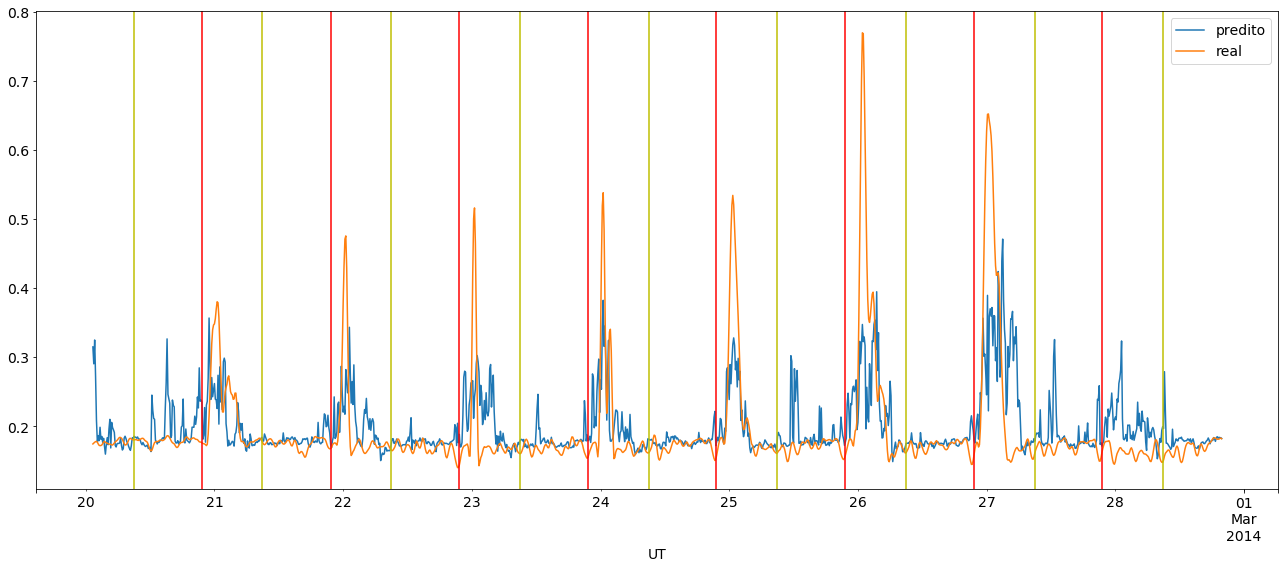

In [6]:
generate_and_avaliate_model(df, original, 's4')

O erro quadrático médio foi: 0.001263
O erro quadrático total foi: 2.076304
O maior erro por previsão foi: 0.371879
O erro relativo foi: 8.701836%
O número de verdadeiros negativos foi: 2731
O número de verdadeiros positivos foi: 250
O número de falsos negativos foi: 125
O número de falsos positivos foi: 308
O POD foi: 0.666667
O FAR foi: 0.551971
A ACC foi: 0.873169
O kappa foi: 0.035895

Error for the time series sample:
O erro quadrático médio foi: 0.004621
O erro quadrático total foi: 2.416705
O maior erro por previsão foi: 0.499196
O erro relativo foi: 18.174358%
O número de verdadeiros negativos foi: 831
O número de verdadeiros positivos foi: 120
O número de falsos negativos foi: 33
O número de falsos positivos foi: 280
O POD foi: 0.784314
O FAR foi: 0.700000
A ACC foi: 0.752373
O kappa foi: 0.038194


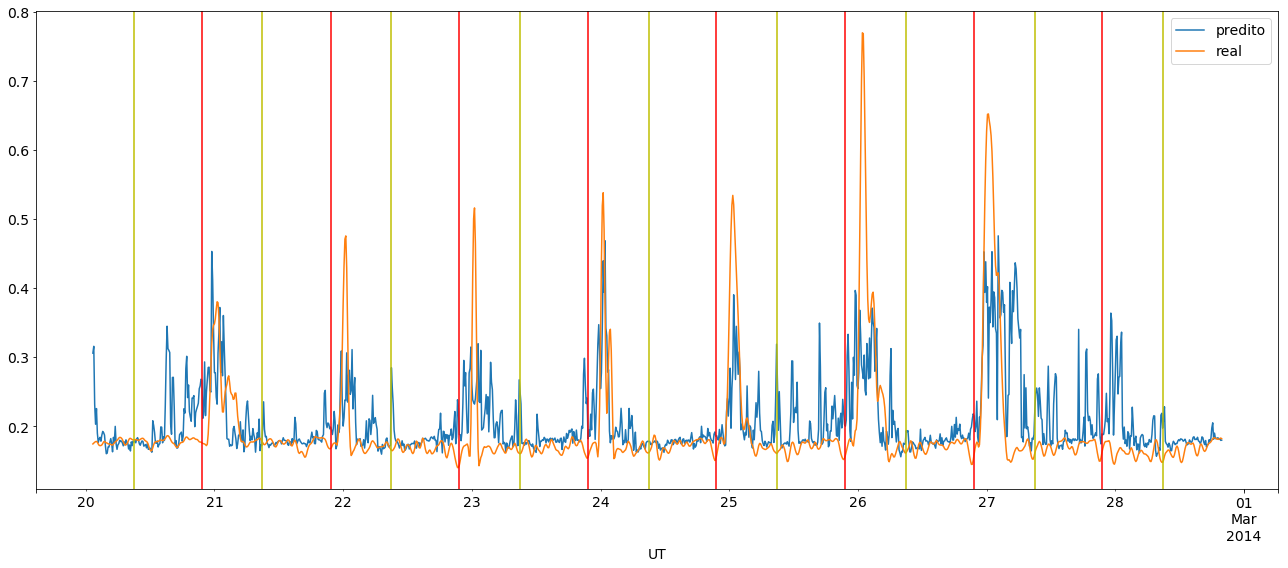

In [7]:
generate_and_avaliate_model(df, ['vtec_dt_lag_3', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.001029
O erro quadrático total foi: 1.874361
O maior erro por previsão foi: 0.301532
O erro relativo foi: 7.569138%
O número de verdadeiros negativos foi: 2816
O número de verdadeiros positivos foi: 294
O número de falsos negativos foi: 81
O número de falsos positivos foi: 223
O POD foi: 0.784000
O FAR foi: 0.431335
A ACC foi: 0.910955
O kappa foi: 0.025195

Error for the time series sample:
O erro quadrático médio foi: 0.004141
O erro quadrático total foi: 2.287901
O maior erro por previsão foi: 0.414201
O erro relativo foi: 14.652782%
O número de verdadeiros negativos foi: 904
O número de verdadeiros positivos foi: 130
O número de falsos negativos foi: 23
O número de falsos positivos foi: 207
O POD foi: 0.849673
O FAR foi: 0.614243
A ACC foi: 0.818038
O kappa foi: 0.029857


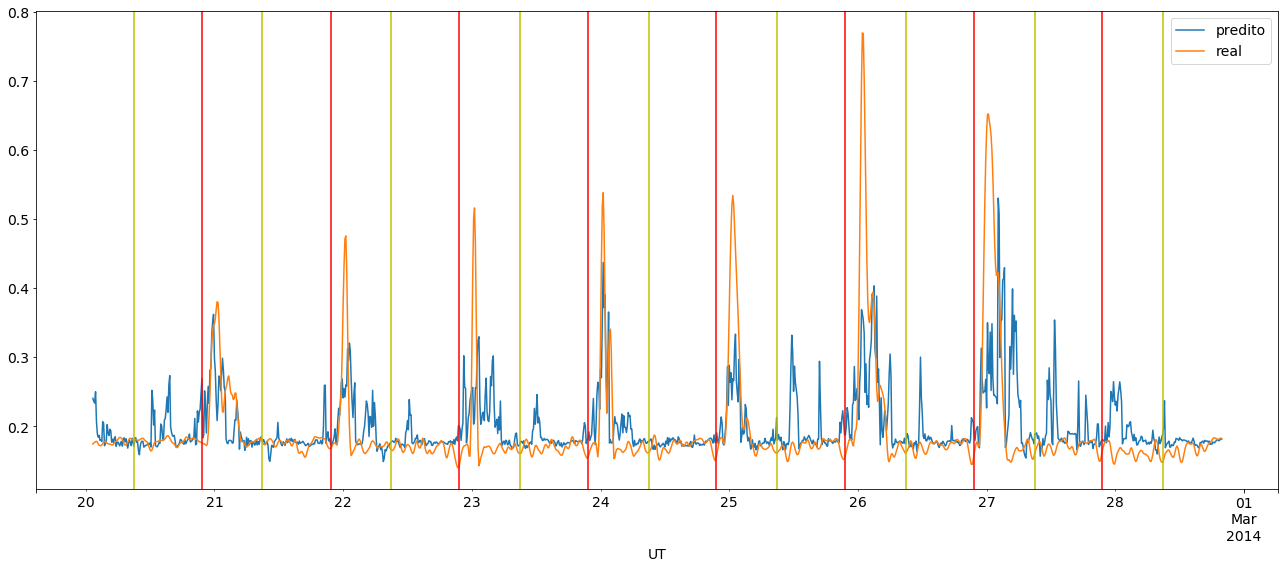

In [8]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.000972
O erro quadrático total foi: 1.821303
O maior erro por previsão foi: 0.381906
O erro relativo foi: 7.184414%
O número de verdadeiros negativos foi: 2797
O número de verdadeiros positivos foi: 299
O número de falsos negativos foi: 76
O número de falsos positivos foi: 242
O POD foi: 0.797333
O FAR foi: 0.447320
A ACC foi: 0.906854
O kappa foi: 0.024446

Error for the time series sample:
O erro quadrático médio foi: 0.003975
O erro quadrático total foi: 2.241526
O maior erro por previsão foi: 0.436412
O erro relativo foi: 14.521984%
O número de verdadeiros negativos foi: 912
O número de verdadeiros positivos foi: 117
O número de falsos negativos foi: 36
O número de falsos positivos foi: 199
O POD foi: 0.764706
O FAR foi: 0.629747
A ACC foi: 0.814082
O kappa foi: 0.035122


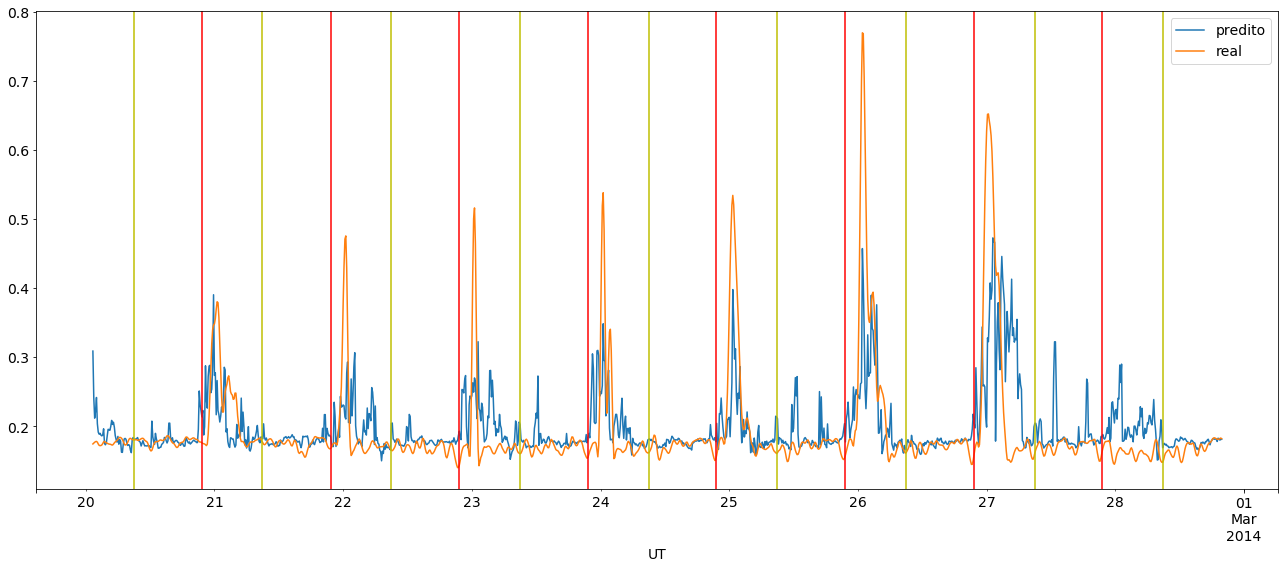

In [9]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt_lag_3', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.001020
O erro quadrático total foi: 1.866527
O maior erro por previsão foi: 0.287717
O erro relativo foi: 7.642793%
O número de verdadeiros negativos foi: 2759
O número de verdadeiros positivos foi: 299
O número de falsos negativos foi: 76
O número de falsos positivos foi: 280
O POD foi: 0.797333
O FAR foi: 0.483592
A ACC foi: 0.895723
O kappa foi: 0.025173

Error for the time series sample:
O erro quadrático médio foi: 0.004259
O erro quadrático total foi: 2.320259
O maior erro por previsão foi: 0.445207
O erro relativo foi: 14.716154%
O número de verdadeiros negativos foi: 893
O número de verdadeiros positivos foi: 123
O número de falsos negativos foi: 30
O número de falsos positivos foi: 218
O POD foi: 0.803922
O FAR foi: 0.639296
A ACC foi: 0.803797
O kappa foi: 0.033551


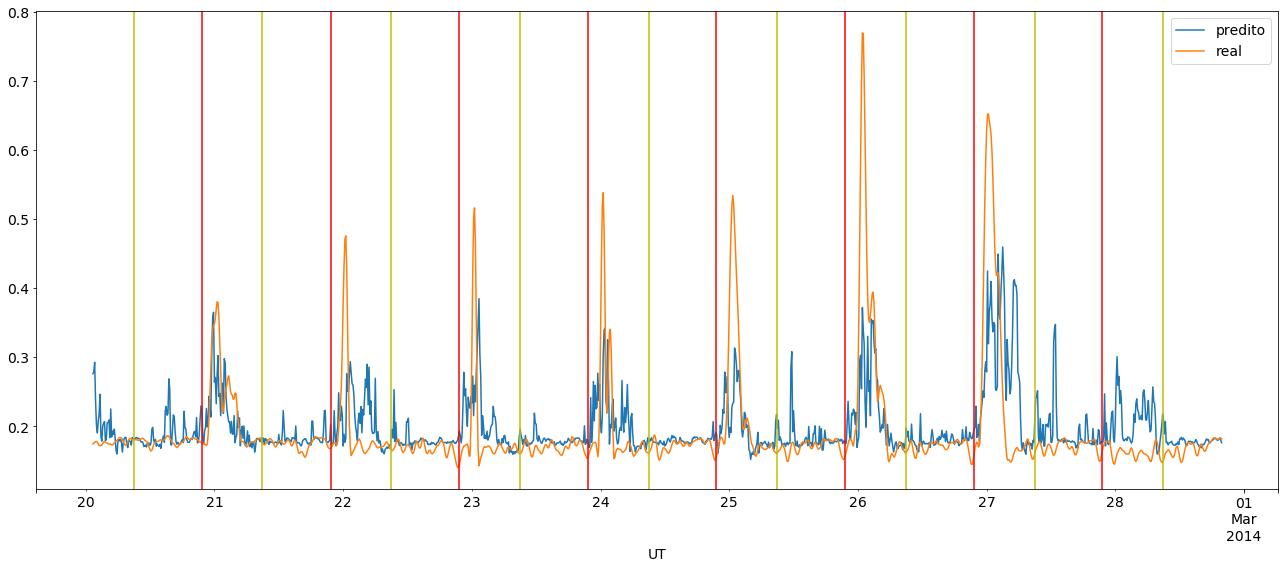

In [10]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt_lag_3', 'vtec_dt2', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.001117
O erro quadrático total foi: 1.952555
O maior erro por previsão foi: 0.378165
O erro relativo foi: 7.591285%
O número de verdadeiros negativos foi: 2802
O número de verdadeiros positivos foi: 284
O número de falsos negativos foi: 91
O número de falsos positivos foi: 237
O POD foi: 0.757333
O FAR foi: 0.454894
A ACC foi: 0.903925
O kappa foi: 0.027652

Error for the time series sample:
O erro quadrático médio foi: 0.004874
O erro quadrático total foi: 2.482040
O maior erro por previsão foi: 0.511014
O erro relativo foi: 14.829397%
O número de verdadeiros negativos foi: 901
O número de verdadeiros positivos foi: 117
O número de falsos negativos foi: 36
O número de falsos positivos foi: 210
O POD foi: 0.764706
O FAR foi: 0.642202
A ACC foi: 0.805380
O kappa foi: 0.035680


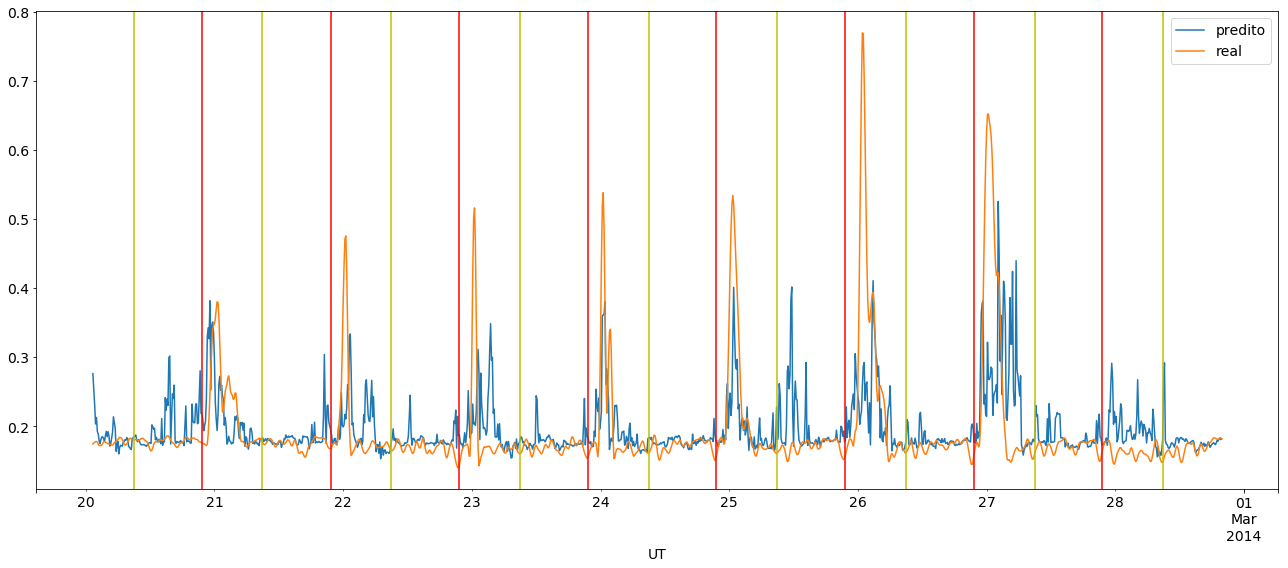

In [11]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt_lag_3', 'vtec_dt2', 'gvtec1', 'gvtec2', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.001202
O erro quadrático total foi: 2.025582
O maior erro por previsão foi: 0.336605
O erro relativo foi: 8.103488%
O número de verdadeiros negativos foi: 2741
O número de verdadeiros positivos foi: 292
O número de falsos negativos foi: 83
O número de falsos positivos foi: 298
O POD foi: 0.778667
O FAR foi: 0.505085
A ACC foi: 0.888401
O kappa foi: 0.026985

Error for the time series sample:
O erro quadrático médio foi: 0.004332
O erro quadrático total foi: 2.340029
O maior erro por previsão foi: 0.468700
O erro relativo foi: 16.404375%
O número de verdadeiros negativos foi: 860
O número de verdadeiros positivos foi: 130
O número de falsos negativos foi: 23
O número de falsos positivos foi: 251
O POD foi: 0.849673
O FAR foi: 0.658793
A ACC foi: 0.783228
O kappa foi: 0.032803


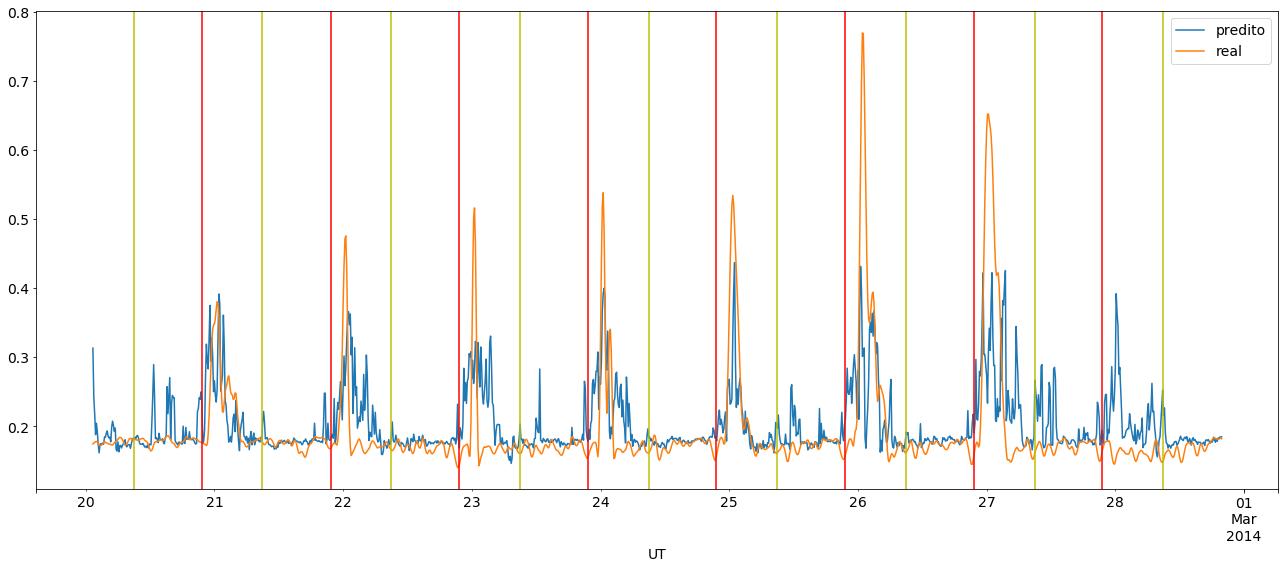

In [12]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt_lag_3', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2_dt'], 's4')

O erro quadrático médio foi: 0.000992
O erro quadrático total foi: 1.840142
O maior erro por previsão foi: 0.337467
O erro relativo foi: 7.173598%
O número de verdadeiros negativos foi: 2808
O número de verdadeiros positivos foi: 292
O número de falsos negativos foi: 83
O número de falsos positivos foi: 231
O POD foi: 0.778667
O FAR foi: 0.441683
A ACC foi: 0.908026
O kappa foi: 0.025783

Error for the time series sample:
O erro quadrático médio foi: 0.003904
O erro quadrático total foi: 2.221291
O maior erro por previsão foi: 0.453869
O erro relativo foi: 14.645862%
O número de verdadeiros negativos foi: 895
O número de verdadeiros positivos foi: 125
O número de falsos negativos foi: 28
O número de falsos positivos foi: 216
O POD foi: 0.816993
O FAR foi: 0.633431
A ACC foi: 0.806962
O kappa foi: 0.032584


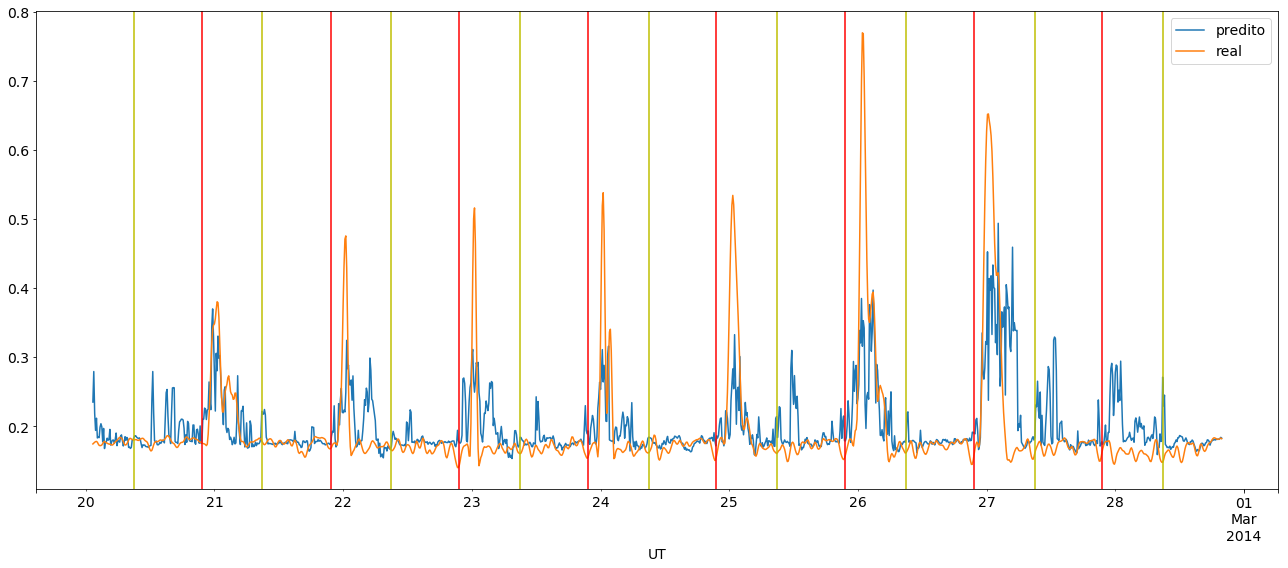

In [13]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt_lag_3', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2'], 's4')

O erro quadrático médio foi: 0.002728
O erro quadrático total foi: 3.051641
O maior erro por previsão foi: 0.413882
O erro relativo foi: 12.461284%
O número de verdadeiros negativos foi: 2628
O número de verdadeiros positivos foi: 127
O número de falsos negativos foi: 248
O número de falsos positivos foi: 411
O POD foi: 0.338667
O FAR foi: 0.763941
A ACC foi: 0.806971
O kappa foi: 0.060396

Error for the time series sample:
O erro quadrático médio foi: 0.006397
O erro quadrático total foi: 2.843502
O maior erro por previsão foi: 0.592680
O erro relativo foi: 14.572030%
O número de verdadeiros negativos foi: 974
O número de verdadeiros positivos foi: 48
O número de falsos negativos foi: 105
O número de falsos positivos foi: 137
O POD foi: 0.313725
O FAR foi: 0.740541
A ACC foi: 0.808544
O kappa foi: 0.068127


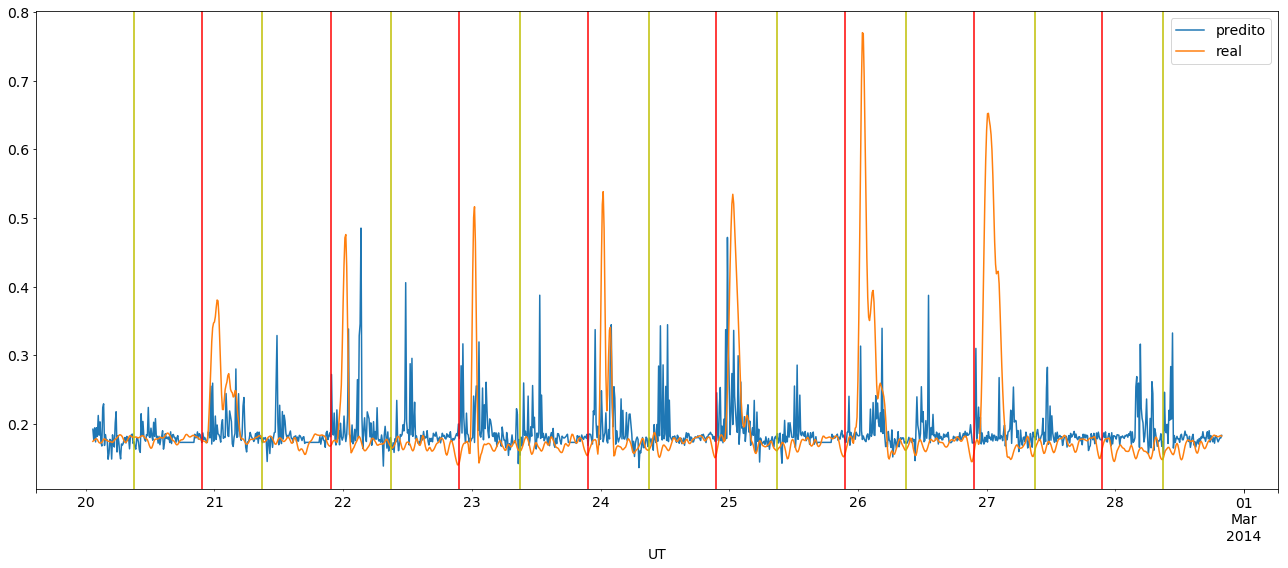

In [14]:
generate_and_avaliate_model(df, ['vtec',], 's4')

O erro quadrático médio foi: 0.001639
O erro quadrático total foi: 2.365716
O maior erro por previsão foi: 0.402360
O erro relativo foi: 9.529794%
O número de verdadeiros negativos foi: 2671
O número de verdadeiros positivos foi: 242
O número de falsos negativos foi: 133
O número de falsos positivos foi: 368
O POD foi: 0.645333
O FAR foi: 0.603279
A ACC foi: 0.853251
O kappa foi: 0.038120

Error for the time series sample:
O erro quadrático médio foi: 0.005411
O erro quadrático total foi: 2.615242
O maior erro por previsão foi: 0.485467
O erro relativo foi: 15.209235%
O número de verdadeiros negativos foi: 929
O número de verdadeiros positivos foi: 102
O número de falsos negativos foi: 51
O número de falsos positivos foi: 182
O POD foi: 0.666667
O FAR foi: 0.640845
A ACC foi: 0.815665
O kappa foi: 0.041274


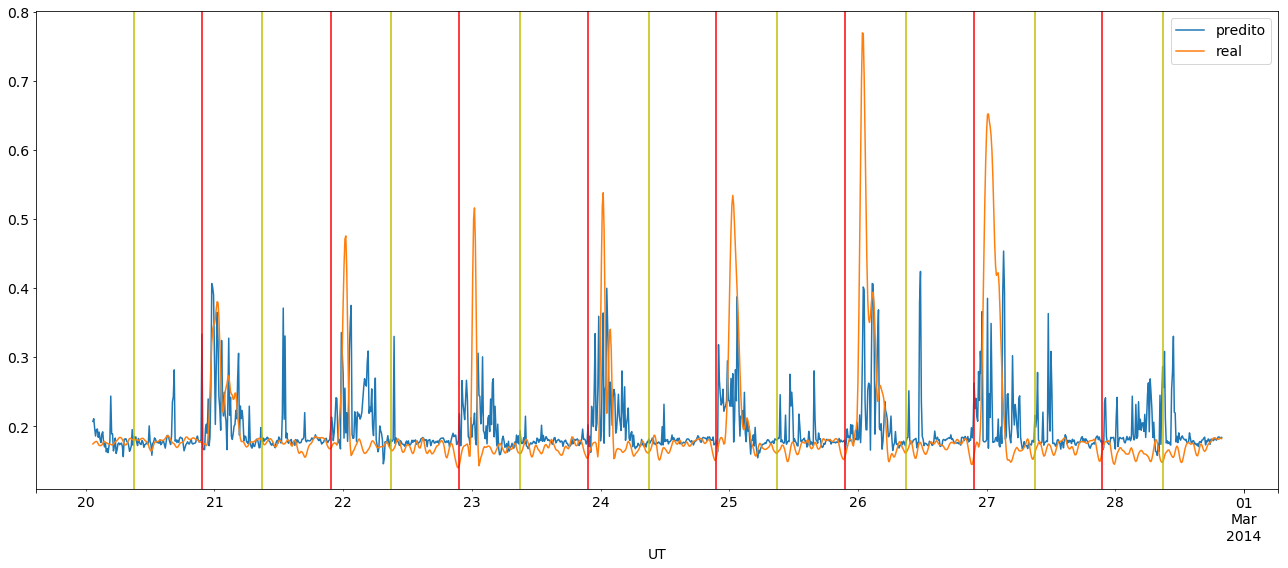

In [15]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt_lag_3', 'vtec_dt2'], 's4')

O erro quadrático médio foi: 0.001516
O erro quadrático total foi: 2.274942
O maior erro por previsão foi: 0.388938
O erro relativo foi: 9.024807%
O número de verdadeiros negativos foi: 2737
O número de verdadeiros positivos foi: 245
O número de falsos negativos foi: 130
O número de falsos positivos foi: 302
O POD foi: 0.653333
O FAR foi: 0.552102
A ACC foi: 0.873462
O kappa foi: 0.036876

Error for the time series sample:
O erro quadrático médio foi: 0.005896
O erro quadrático total foi: 2.730018
O maior erro por previsão foi: 0.586114
O erro relativo foi: 14.810433%
O número de verdadeiros negativos foi: 960
O número de verdadeiros positivos foi: 91
O número de falsos negativos foi: 62
O número de falsos positivos foi: 151
O POD foi: 0.594771
O FAR foi: 0.623967
A ACC foi: 0.831487
O kappa foi: 0.045854


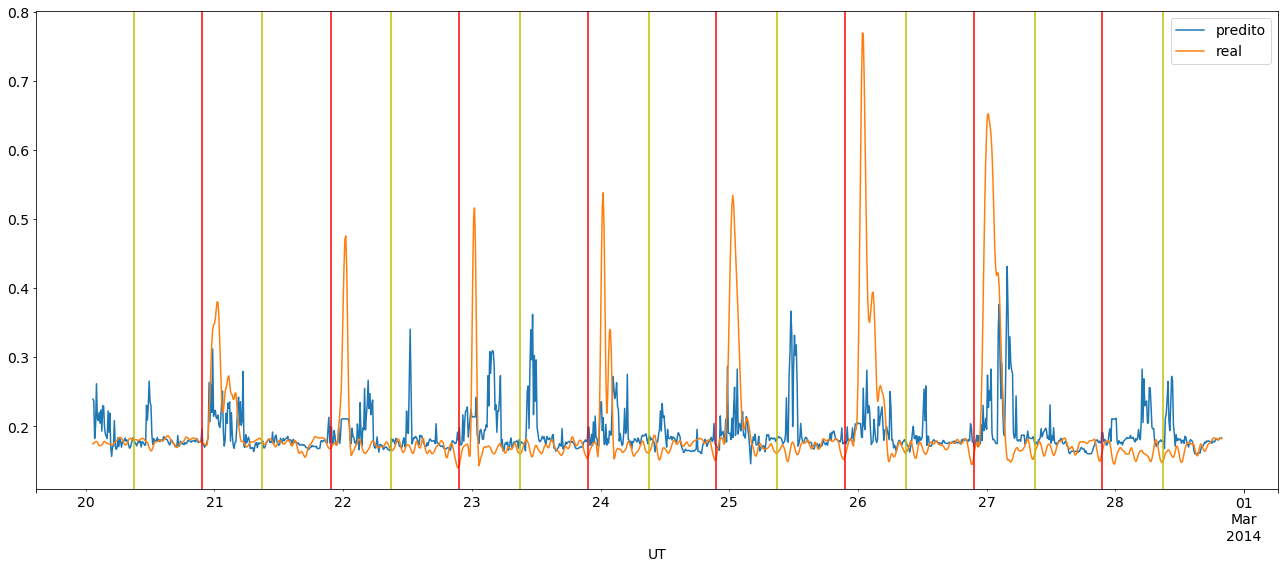

In [16]:
generate_and_avaliate_model(df, ['vtec', 'gvtec1', 'gvtec2'], 's4')

O erro quadrático médio foi: 0.001213
O erro quadrático total foi: 2.035274
O maior erro por previsão foi: 0.374273
O erro relativo foi: 8.162809%
O número de verdadeiros negativos foi: 2753
O número de verdadeiros positivos foi: 275
O número de falsos negativos foi: 100
O número de falsos positivos foi: 286
O POD foi: 0.733333
O FAR foi: 0.509804
A ACC foi: 0.886936
O kappa foi: 0.030368

Error for the time series sample:
O erro quadrático médio foi: 0.004455
O erro quadrático total foi: 2.372889
O maior erro por previsão foi: 0.459224
O erro relativo foi: 15.171878%
O número de verdadeiros negativos foi: 908
O número de verdadeiros positivos foi: 133
O número de falsos negativos foi: 20
O número de falsos positivos foi: 203
O POD foi: 0.869281
O FAR foi: 0.604167
A ACC foi: 0.823576
O kappa foi: 0.028265


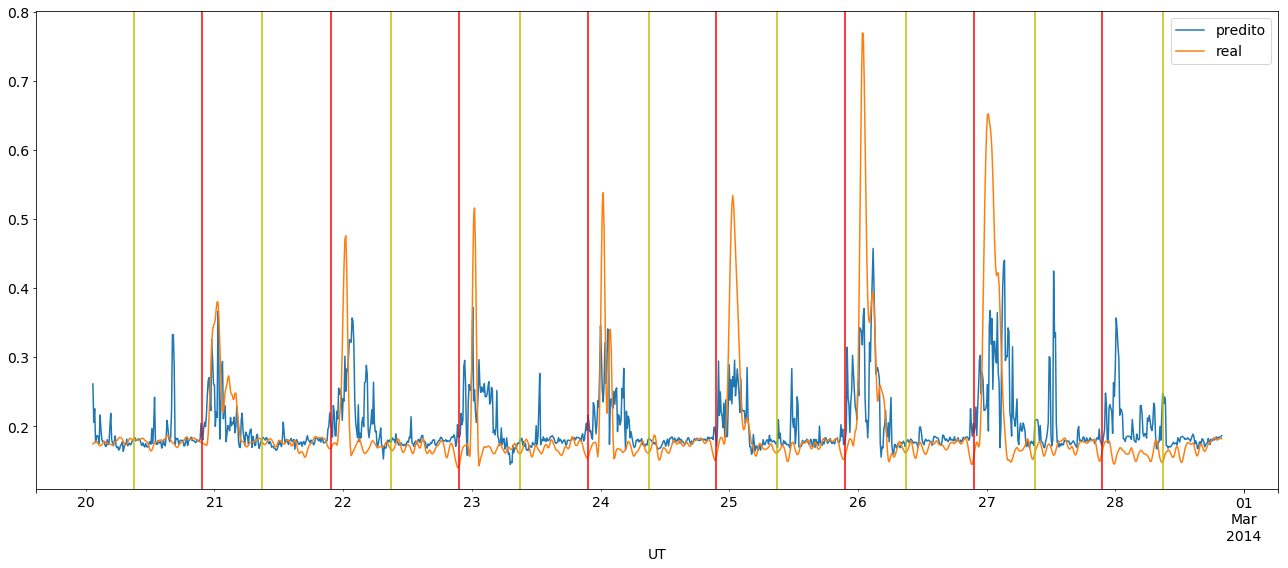

In [17]:
generate_and_avaliate_model(df, ['vtec', 'vtec_dt_lag_3', 'vtec_dt2', 'gvtec1', 'gvtec1_dt'], 's4')

O erro quadrático médio foi: 0.000890
O erro quadrático total foi: 1.742938
O maior erro por previsão foi: 0.273437
O erro relativo foi: 6.977436%
O número de verdadeiros negativos foi: 2845
O número de verdadeiros positivos foi: 312
O número de falsos negativos foi: 63
O número de falsos positivos foi: 194
O POD foi: 0.832000
O FAR foi: 0.383399
A ACC foi: 0.924722
O kappa foi: 0.020571

Error for the time series sample:
O erro quadrático médio foi: 0.003826
O erro quadrático total foi: 2.198982
O maior erro por previsão foi: 0.491839
O erro relativo foi: 14.091646%
O número de verdadeiros negativos foi: 919
O número de verdadeiros positivos foi: 135
O número de falsos negativos foi: 18
O número de falsos positivos foi: 192
O POD foi: 0.882353
O FAR foi: 0.587156
A ACC foi: 0.833861
O kappa foi: 0.026577


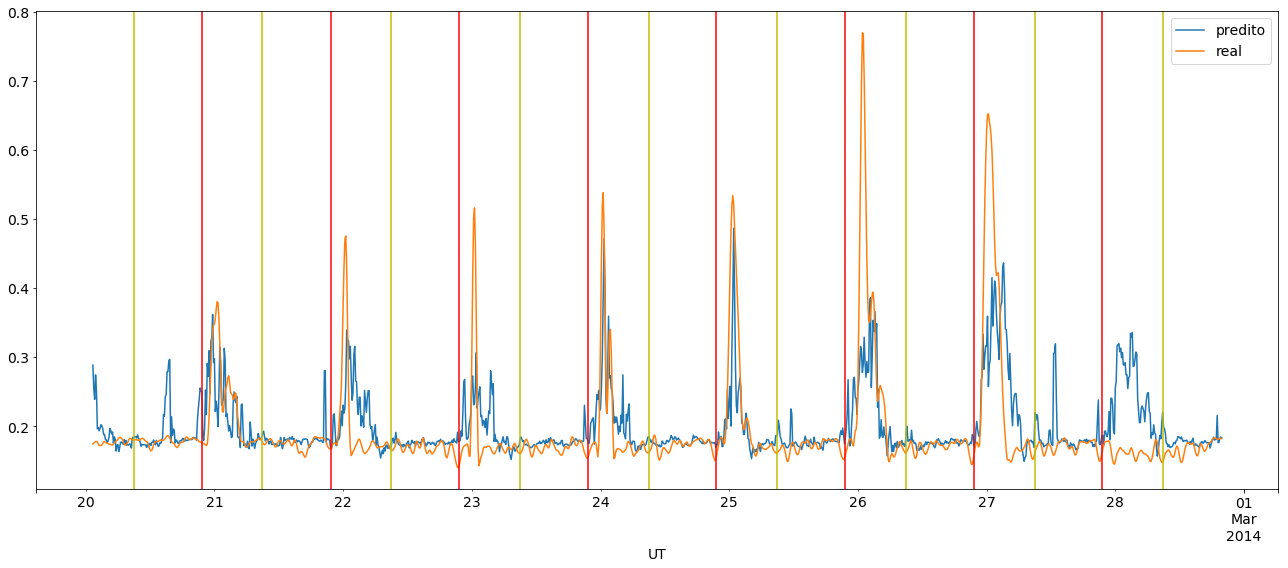

In [18]:
generate_and_avaliate_model(df, original + tempo, 's4')

O erro quadrático médio foi: 0.000881
O erro quadrático total foi: 1.733917
O maior erro por previsão foi: 0.362405
O erro relativo foi: 6.783729%
O número de verdadeiros negativos foi: 2831
O número de verdadeiros positivos foi: 298
O número de falsos negativos foi: 77
O número de falsos positivos foi: 208
O POD foi: 0.794667
O FAR foi: 0.411067
A ACC foi: 0.916520
O kappa foi: 0.024021

Error for the time series sample:
O erro quadrático médio foi: 0.004119
O erro quadrático total foi: 2.281648
O maior erro por previsão foi: 0.511030
O erro relativo foi: 15.271964%
O número de verdadeiros negativos foi: 895
O número de verdadeiros positivos foi: 132
O número de falsos negativos foi: 21
O número de falsos positivos foi: 216
O POD foi: 0.862745
O FAR foi: 0.620690
A ACC foi: 0.812500
O kappa foi: 0.029610


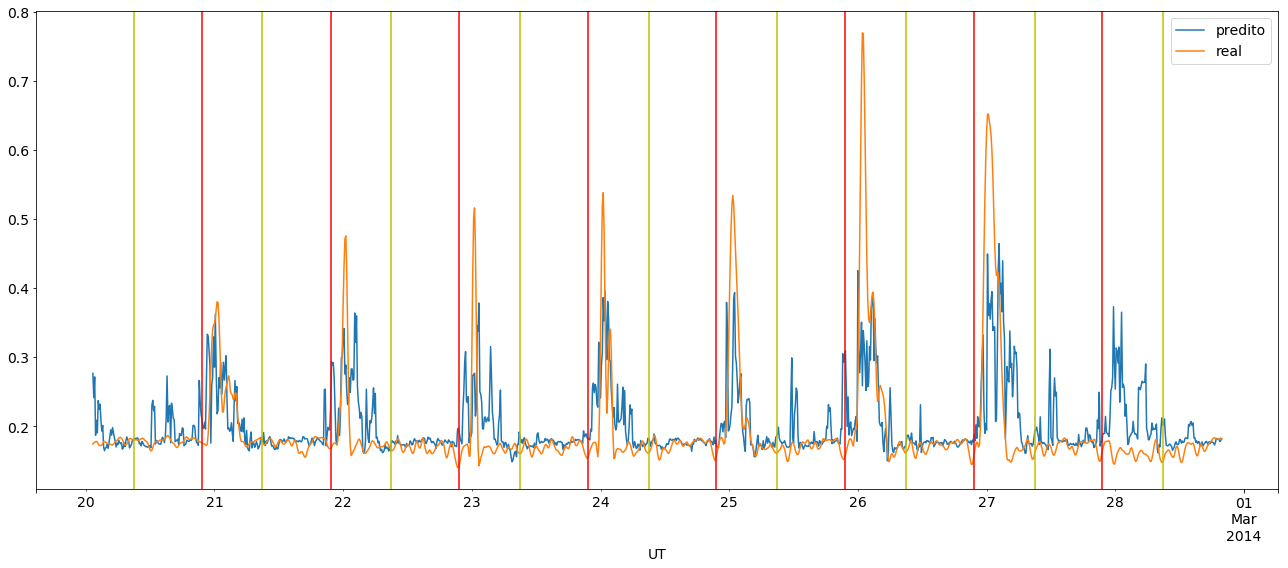

In [19]:
generate_and_avaliate_model(df, original + lag, 's4')

O erro quadrático médio foi: 0.000970
O erro quadrático total foi: 1.819486
O maior erro por previsão foi: 0.342919
O erro relativo foi: 7.162311%
O número de verdadeiros negativos foi: 2821
O número de verdadeiros positivos foi: 310
O número de falsos negativos foi: 65
O número de falsos positivos foi: 218
O POD foi: 0.826667
O FAR foi: 0.412879
A ACC foi: 0.917106
O kappa foi: 0.021530

Error for the time series sample:
O erro quadrático médio foi: 0.003759
O erro quadrático total foi: 2.179817
O maior erro por previsão foi: 0.459283
O erro relativo foi: 14.114857%
O número de verdadeiros negativos foi: 911
O número de verdadeiros positivos foi: 132
O número de falsos negativos foi: 21
O número de falsos positivos foi: 200
O POD foi: 0.862745
O FAR foi: 0.602410
A ACC foi: 0.825158
O kappa foi: 0.028498


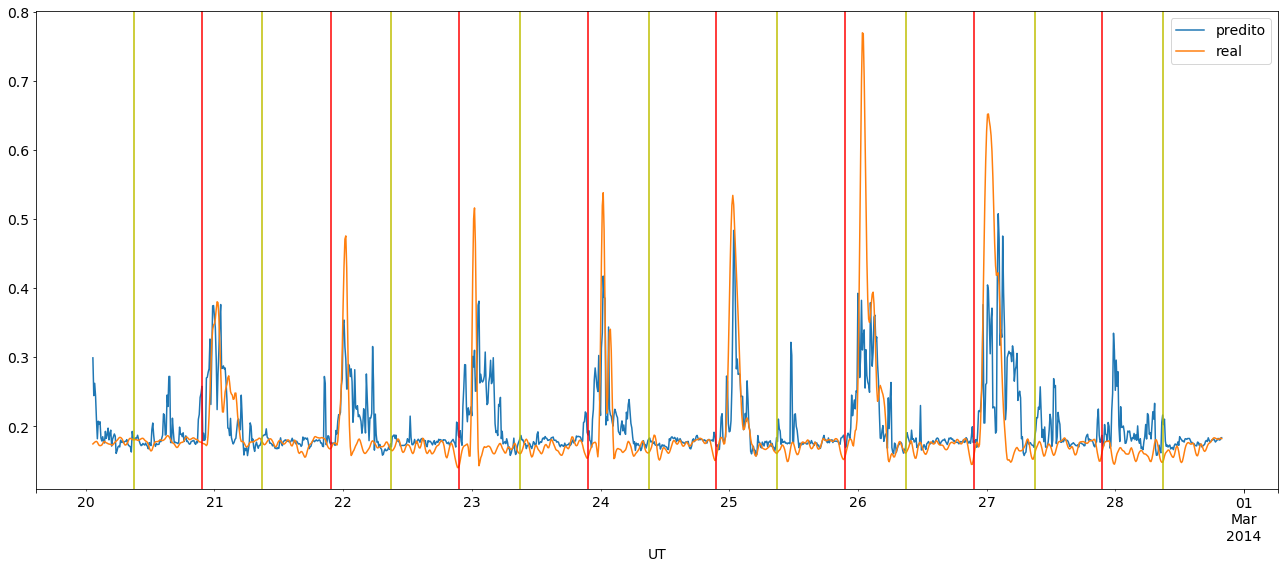

In [20]:
generate_and_avaliate_model(df, original + ['gvtec1_dt_lag_9',], 's4')

O erro quadrático médio foi: 0.000866
O erro quadrático total foi: 1.719516
O maior erro por previsão foi: 0.270661
O erro relativo foi: 6.892513%
O número de verdadeiros negativos foi: 2818
O número de verdadeiros positivos foi: 309
O número de falsos negativos foi: 66
O número de falsos positivos foi: 221
O POD foi: 0.824000
O FAR foi: 0.416981
A ACC foi: 0.915934
O kappa foi: 0.021816

Error for the time series sample:
O erro quadrático médio foi: 0.004082
O erro quadrático total foi: 2.271536
O maior erro por previsão foi: 0.508168
O erro relativo foi: 15.296747%
O número de verdadeiros negativos foi: 886
O número de verdadeiros positivos foi: 125
O número de falsos negativos foi: 28
O número de falsos positivos foi: 225
O POD foi: 0.816993
O FAR foi: 0.642857
A ACC foi: 0.799842
O kappa foi: 0.033131


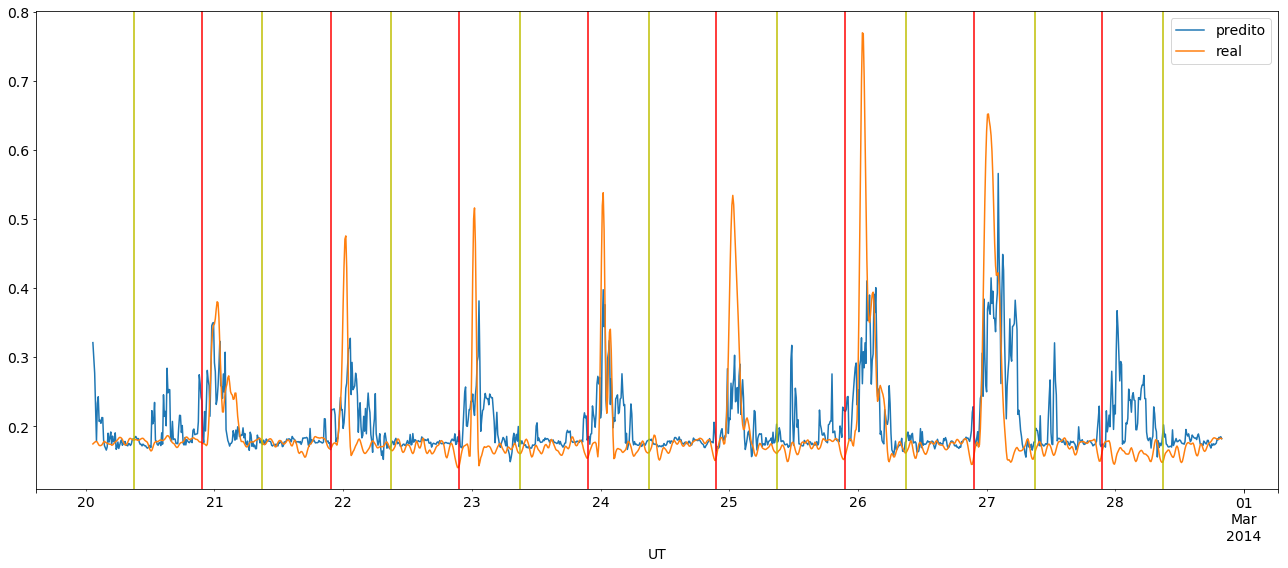

In [21]:
generate_and_avaliate_model(df, original + ['gvtec2_dt_lag_20',], 's4')

O erro quadrático médio foi: 0.000702
O erro quadrático total foi: 1.547993
O maior erro por previsão foi: 0.298493
O erro relativo foi: 5.913646%
O número de verdadeiros negativos foi: 2855
O número de verdadeiros positivos foi: 314
O número de falsos negativos foi: 61
O número de falsos positivos foi: 184
O POD foi: 0.837333
O FAR foi: 0.369478
A ACC foi: 0.928237
O kappa foi: 0.019899

Error for the time series sample:
O erro quadrático médio foi: 0.004525
O erro quadrático total foi: 2.391656
O maior erro por previsão foi: 0.453535
O erro relativo foi: 15.204554%
O número de verdadeiros negativos foi: 904
O número de verdadeiros positivos foi: 120
O número de falsos negativos foi: 33
O número de falsos positivos foi: 207
O POD foi: 0.784314
O FAR foi: 0.633028
A ACC foi: 0.810127
O kappa foi: 0.034219


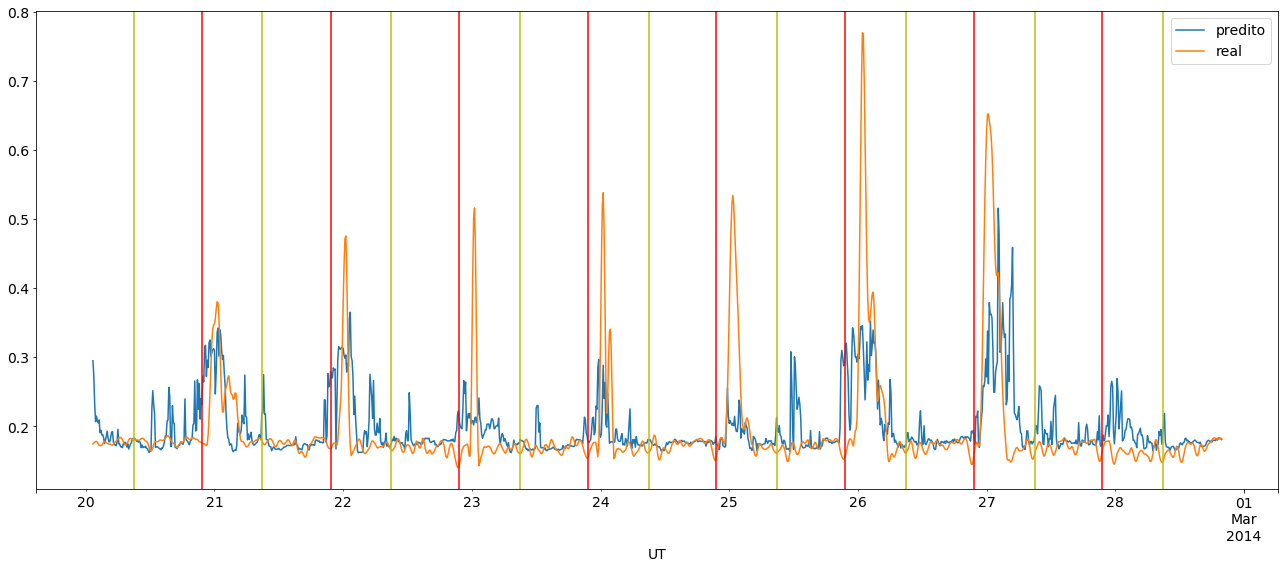

In [22]:
generate_and_avaliate_model(df, original + mdv1, 's4')

O erro quadrático médio foi: 0.000787
O erro quadrático total foi: 1.639095
O maior erro por previsão foi: 0.275717
O erro relativo foi: 6.152457%
O número de verdadeiros negativos foi: 2831
O número de verdadeiros positivos foi: 317
O número de falsos negativos foi: 58
O número de falsos positivos foi: 208
O POD foi: 0.845333
O FAR foi: 0.396190
A ACC foi: 0.922086
O kappa foi: 0.019745

Error for the time series sample:
O erro quadrático médio foi: 0.004501
O erro quadrático total foi: 2.385284
O maior erro por previsão foi: 0.463389
O erro relativo foi: 14.631835%
O número de verdadeiros negativos foi: 916
O número de verdadeiros positivos foi: 105
O número de falsos negativos foi: 48
O número de falsos positivos foi: 195
O POD foi: 0.686275
O FAR foi: 0.650000
A ACC foi: 0.807753
O kappa foi: 0.040335


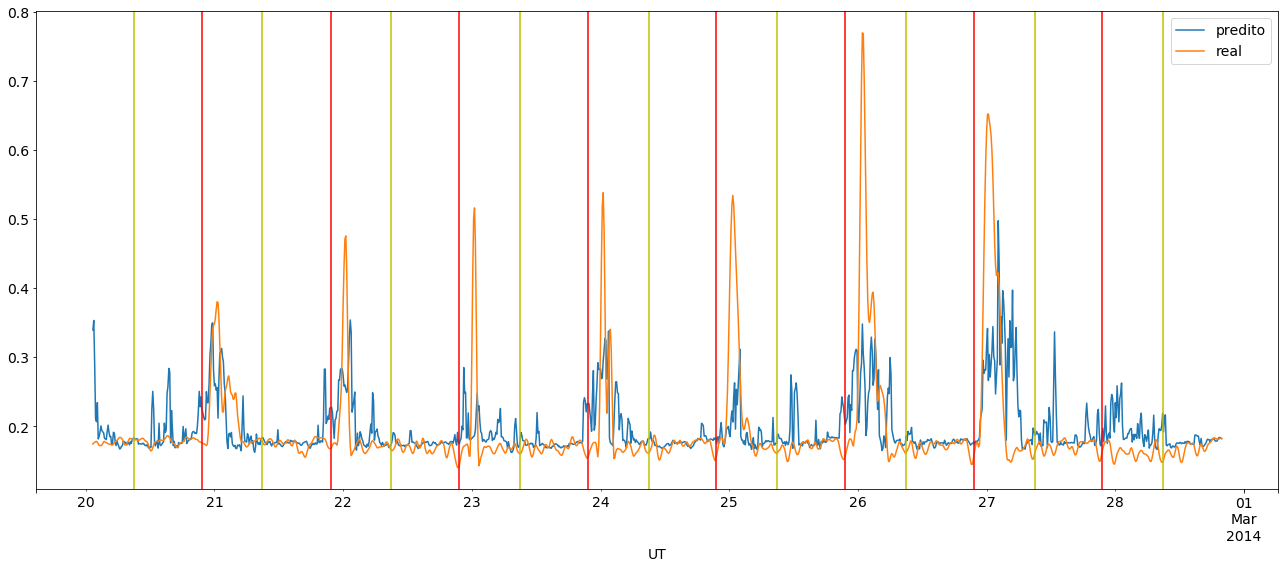

In [23]:
generate_and_avaliate_model(df, original + mdv2, 's4')

O erro quadrático médio foi: 0.000706
O erro quadrático total foi: 1.552918
O maior erro por previsão foi: 0.295337
O erro relativo foi: 6.170182%
O número de verdadeiros negativos foi: 2879
O número de verdadeiros positivos foi: 311
O número de falsos negativos foi: 64
O número de falsos positivos foi: 160
O POD foi: 0.829333
O FAR foi: 0.339703
A ACC foi: 0.934388
O kappa foi: 0.020078

Error for the time series sample:
O erro quadrático médio foi: 0.003425
O erro quadrático total foi: 2.080652
O maior erro por previsão foi: 0.432110
O erro relativo foi: 14.221021%
O número de verdadeiros negativos foi: 907
O número de verdadeiros positivos foi: 131
O número de falsos negativos foi: 22
O número de falsos positivos foi: 204
O POD foi: 0.856209
O FAR foi: 0.608955
A ACC foi: 0.821203
O kappa foi: 0.029216


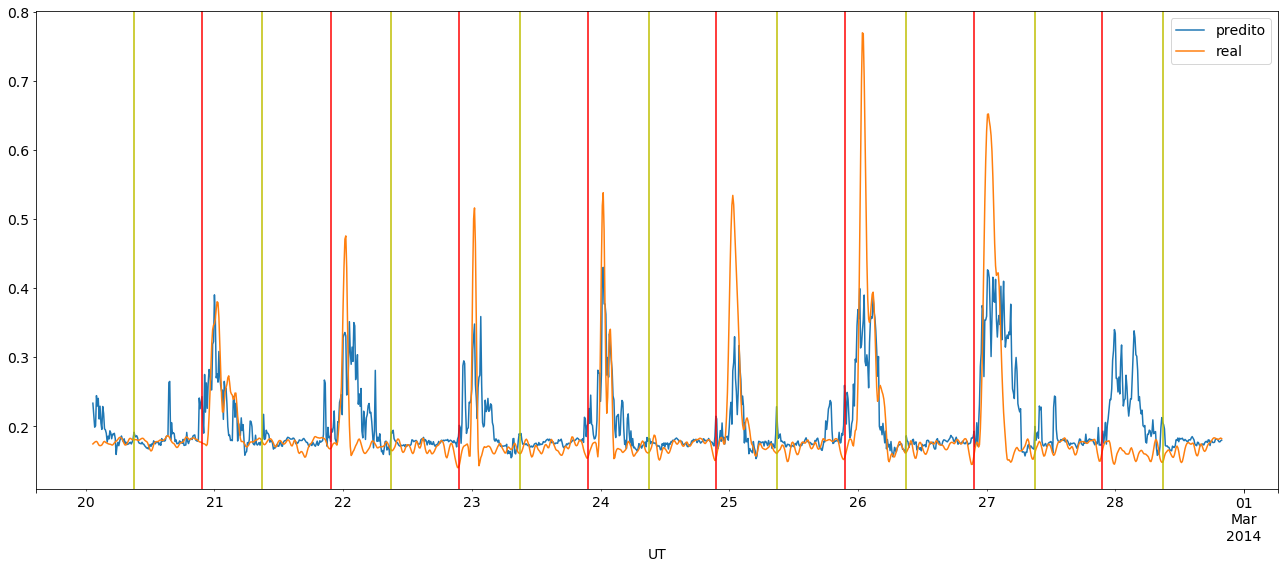

In [24]:
generate_and_avaliate_model(df, original + tempo + lag, 's4')

O erro quadrático médio foi: 0.000651
O erro quadrático total foi: 1.491090
O maior erro por previsão foi: 0.227391
O erro relativo foi: 5.508812%
O número de verdadeiros negativos foi: 2893
O número de verdadeiros positivos foi: 324
O número de falsos negativos foi: 51
O número de falsos positivos foi: 146
O POD foi: 0.864000
O FAR foi: 0.310638
A ACC foi: 0.942296
O kappa foi: 0.016717

Error for the time series sample:
O erro quadrático médio foi: 0.004170
O erro quadrático total foi: 2.295860
O maior erro por previsão foi: 0.443803
O erro relativo foi: 13.933517%
O número de verdadeiros negativos foi: 938
O número de verdadeiros positivos foi: 116
O número de falsos negativos foi: 37
O número de falsos positivos foi: 173
O POD foi: 0.758170
O FAR foi: 0.598616
A ACC foi: 0.833861
O kappa foi: 0.034283


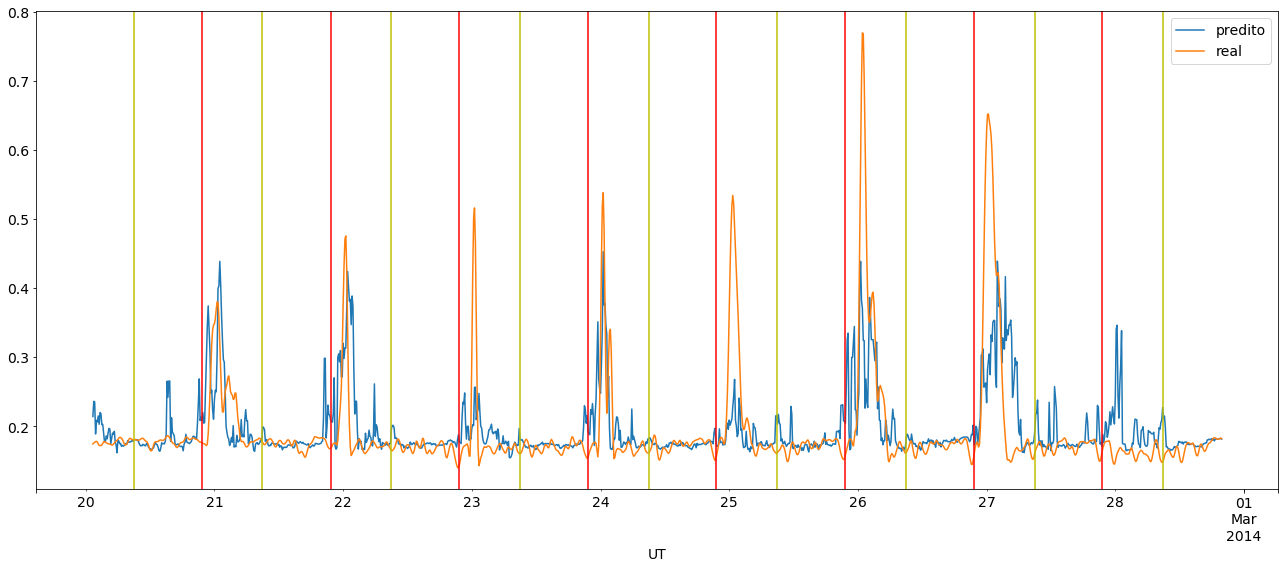

In [25]:
generate_and_avaliate_model(df, original + tempo + mdv2, 's4')

O erro quadrático médio foi: 0.000629
O erro quadrático total foi: 1.465762
O maior erro por previsão foi: 0.277540
O erro relativo foi: 5.343075%
O número de verdadeiros negativos foi: 2896
O número de verdadeiros positivos foi: 321
O número de falsos negativos foi: 54
O número de falsos positivos foi: 143
O POD foi: 0.856000
O FAR foi: 0.308190
A ACC foi: 0.942296
O kappa foi: 0.017356

Error for the time series sample:
O erro quadrático médio foi: 0.004080
O erro quadrático total foi: 2.271044
O maior erro por previsão foi: 0.502499
O erro relativo foi: 13.074861%
O número de verdadeiros negativos foi: 946
O número de verdadeiros positivos foi: 117
O número de falsos negativos foi: 36
O número de falsos positivos foi: 165
O POD foi: 0.764706
O FAR foi: 0.585106
A ACC foi: 0.840981
O kappa foi: 0.033399


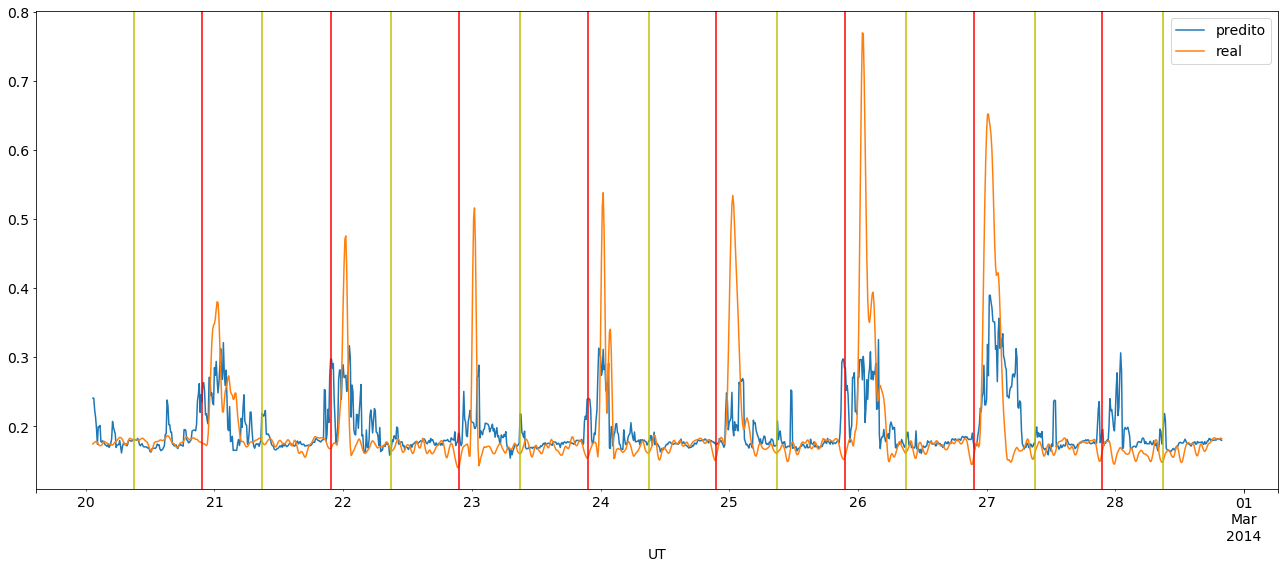

In [26]:
generate_and_avaliate_model(df, original + tempo + mdv2 + lag, 's4')

O erro quadrático médio foi: 0.001608
O erro quadrático total foi: 2.343335
O maior erro por previsão foi: 0.379366
O erro relativo foi: 9.642298%
O número de verdadeiros negativos foi: 2681
O número de verdadeiros positivos foi: 213
O número de falsos negativos foi: 162
O número de falsos positivos foi: 358
O POD foi: 0.568000
O FAR foi: 0.626970
A ACC foi: 0.847686
O kappa foi: 0.043806

Error for the time series sample:
O erro quadrático médio foi: 0.003466
O erro quadrático total foi: 2.093018
O maior erro por previsão foi: 0.442510
O erro relativo foi: 15.210463%
O número de verdadeiros negativos foi: 904
O número de verdadeiros positivos foi: 120
O número de falsos negativos foi: 33
O número de falsos positivos foi: 207
O POD foi: 0.784314
O FAR foi: 0.633028
A ACC foi: 0.810127
O kappa foi: 0.034219


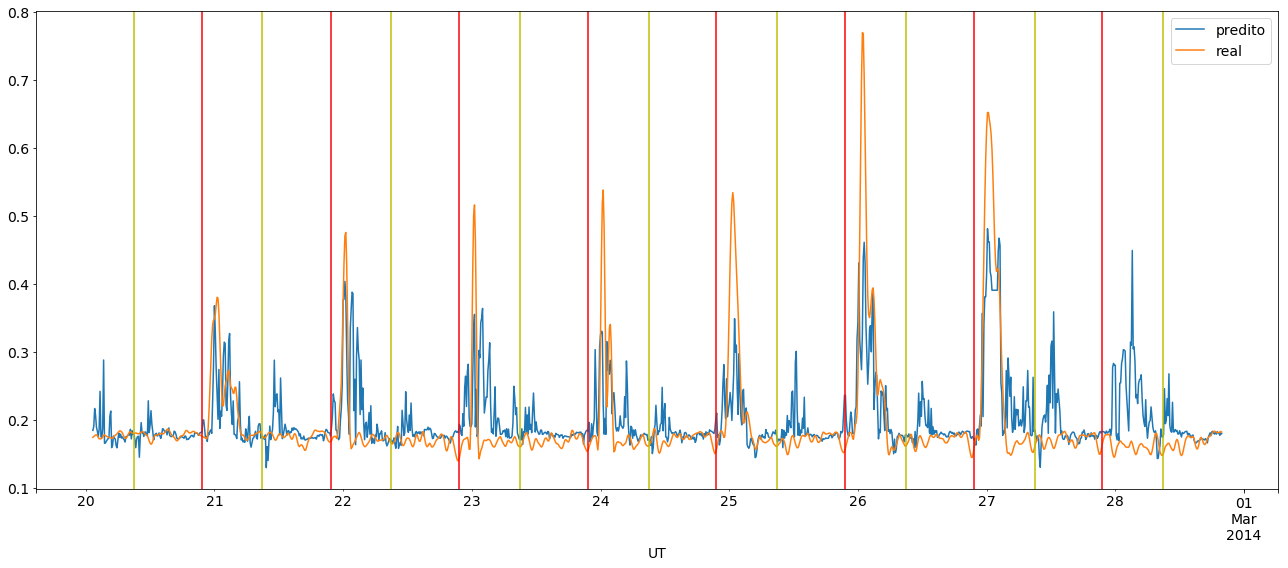

In [27]:
generate_and_avaliate_model(df, ['vtec',] + lag, 's4')

O erro quadrático médio foi: 0.002130
O erro quadrático total foi: 2.696369
O maior erro por previsão foi: 0.389374
O erro relativo foi: 11.287402%
O número de verdadeiros negativos foi: 2611
O número de verdadeiros positivos foi: 166
O número de falsos negativos foi: 209
O número de falsos positivos foi: 428
O POD foi: 0.442667
O FAR foi: 0.720539
A ACC foi: 0.813415
O kappa foi: 0.052915

Error for the time series sample:
O erro quadrático médio foi: 0.004403
O erro quadrático total foi: 2.359180
O maior erro por previsão foi: 0.513444
O erro relativo foi: 15.842940%
O número de verdadeiros negativos foi: 899
O número de verdadeiros positivos foi: 111
O número de falsos negativos foi: 42
O número de falsos positivos foi: 212
O POD foi: 0.725490
O FAR foi: 0.656347
A ACC foi: 0.799051
O kappa foi: 0.038361


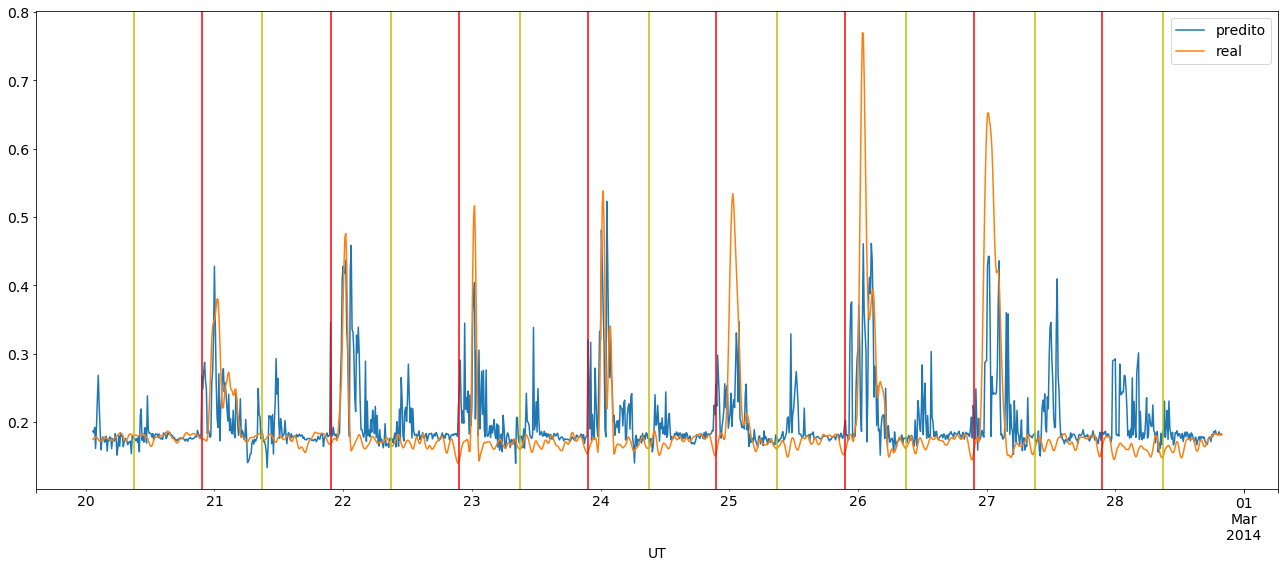

In [28]:
generate_and_avaliate_model(df, ['vtec', 'gvtec1_dt_lag_9'], 's4')

O erro quadrático médio foi: 0.001934
O erro quadrático total foi: 2.569783
O maior erro por previsão foi: 0.384431
O erro relativo foi: 10.621449%
O número de verdadeiros negativos foi: 2638
O número de verdadeiros positivos foi: 200
O número de falsos negativos foi: 175
O número de falsos positivos foi: 401
O POD foi: 0.533333
O FAR foi: 0.667221
A ACC foi: 0.831283
O kappa foi: 0.046489

Error for the time series sample:
O erro quadrático médio foi: 0.004229
O erro quadrático total foi: 2.311901
O maior erro por previsão foi: 0.481442
O erro relativo foi: 14.608360%
O número de verdadeiros negativos foi: 946
O número de verdadeiros positivos foi: 85
O número de falsos negativos foi: 68
O número de falsos positivos foi: 165
O POD foi: 0.555556
O FAR foi: 0.660000
A ACC foi: 0.815665
O kappa foi: 0.049041


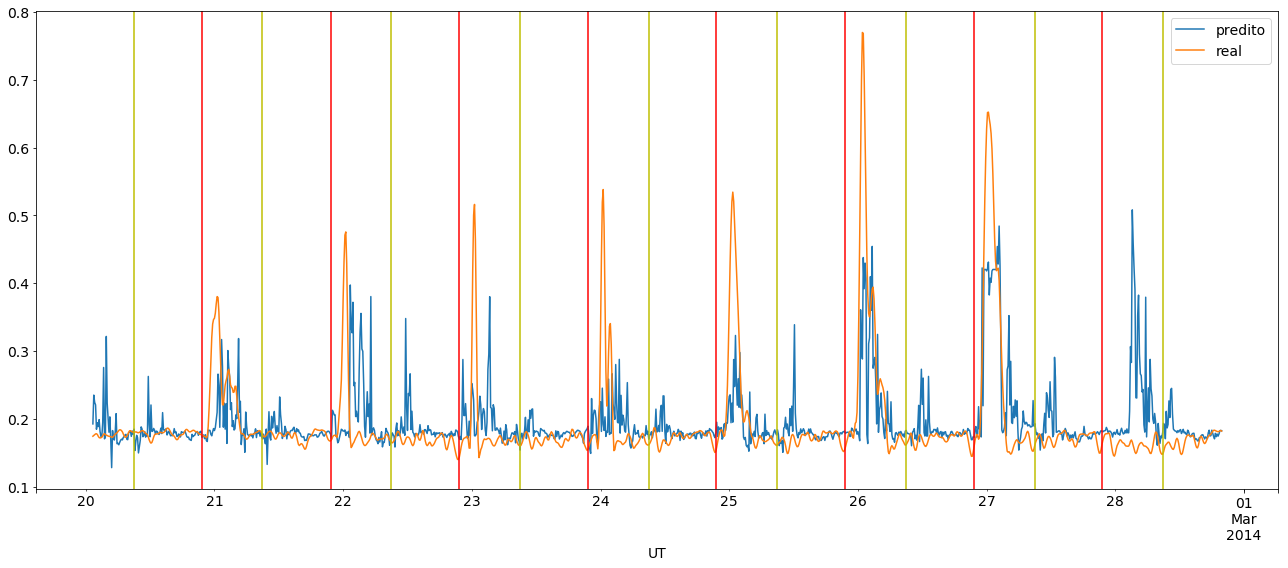

In [29]:
generate_and_avaliate_model(df, ['vtec', 'gvtec2_dt_lag_20'], 's4')

O erro quadrático médio foi: 0.002157
O erro quadrático total foi: 2.713911
O maior erro por previsão foi: 0.405107
O erro relativo foi: 10.491358%
O número de verdadeiros negativos foi: 2802
O número de verdadeiros positivos foi: 211
O número de falsos negativos foi: 164
O número de falsos positivos foi: 237
O POD foi: 0.562667
O FAR foi: 0.529018
A ACC foi: 0.882542
O kappa foi: 0.043717

Error for the time series sample:
O erro quadrático médio foi: 0.005584
O erro quadrático total foi: 2.656674
O maior erro por previsão foi: 0.495865
O erro relativo foi: 16.210484%
O número de verdadeiros negativos foi: 956
O número de verdadeiros positivos foi: 120
O número de falsos negativos foi: 33
O número de falsos positivos foi: 155
O POD foi: 0.784314
O FAR foi: 0.563636
A ACC foi: 0.851266
O kappa foi: 0.031388


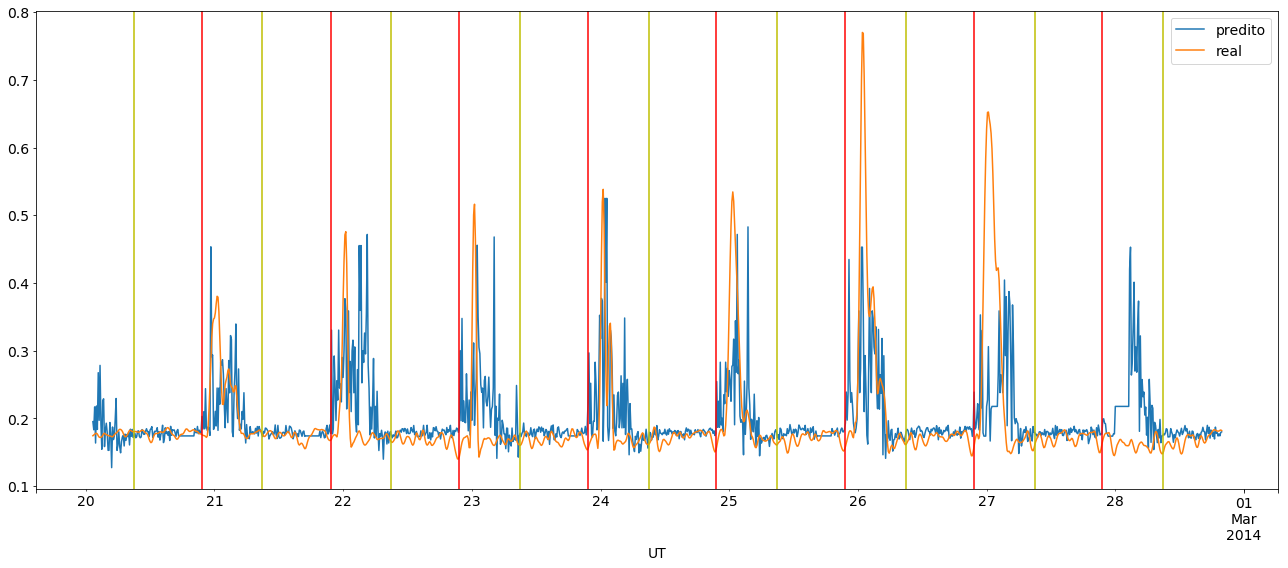

In [30]:
generate_and_avaliate_model(df, ['vtec',] + tempo, 's4')

O erro quadrático médio foi: 0.002196
O erro quadrático total foi: 2.738029
O maior erro por previsão foi: 0.423197
O erro relativo foi: 10.481258%
O número de verdadeiros negativos foi: 2803
O número de verdadeiros positivos foi: 221
O número de falsos negativos foi: 154
O número de falsos positivos foi: 236
O POD foi: 0.589333
O FAR foi: 0.516411
A ACC foi: 0.885764
O kappa foi: 0.041510

Error for the time series sample:
O erro quadrático médio foi: 0.005607
O erro quadrático total foi: 2.662241
O maior erro por previsão foi: 0.506268
O erro relativo foi: 16.160378%
O número de verdadeiros negativos foi: 952
O número de verdadeiros positivos foi: 119
O número de falsos negativos foi: 34
O número de falsos positivos foi: 159
O POD foi: 0.777778
O FAR foi: 0.571942
A ACC foi: 0.847310
O kappa foi: 0.032102


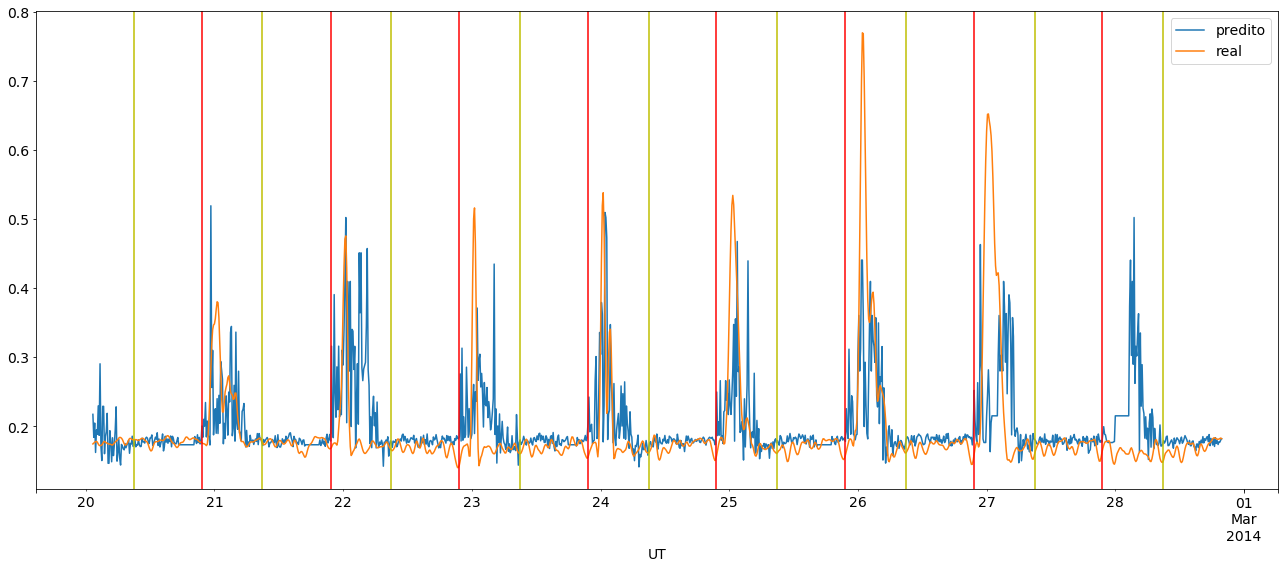

In [31]:
generate_and_avaliate_model(df, ['vtec',] + tempo, 's4')

O erro quadrático médio foi: 0.000982
O erro quadrático total foi: 1.831032
O maior erro por previsão foi: 0.384468
O erro relativo foi: 6.210675%
O número de verdadeiros negativos foi: 2883
O número de verdadeiros positivos foi: 289
O número de falsos negativos foi: 86
O número de falsos positivos foi: 156
O POD foi: 0.770667
O FAR foi: 0.350562
A ACC foi: 0.929115
O kappa foi: 0.025140

Error for the time series sample:
O erro quadrático médio foi: 0.005592
O erro quadrático total foi: 2.658567
O maior erro por previsão foi: 0.595025
O erro relativo foi: 12.517162%
O número de verdadeiros negativos foi: 1049
O número de verdadeiros positivos foi: 69
O número de falsos negativos foi: 84
O número de falsos positivos foi: 62
O POD foi: 0.450980
O FAR foi: 0.473282
A ACC foi: 0.884494
O kappa foi: 0.057830


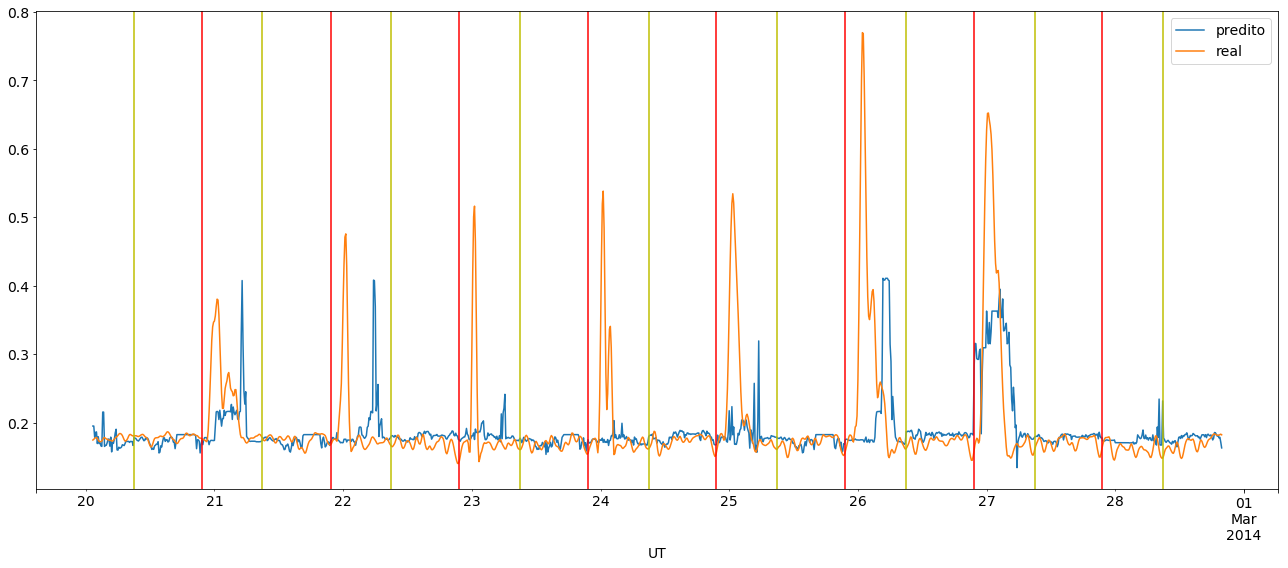

In [32]:
generate_and_avaliate_model(df, ['vtec',] + tempo + mdv1, 's4')

O erro quadrático médio foi: 0.000952
O erro quadrático total foi: 1.802880
O maior erro por previsão foi: 0.365967
O erro relativo foi: 6.119161%
O número de verdadeiros negativos foi: 2903
O número de verdadeiros positivos foi: 293
O número de falsos negativos foi: 82
O número de falsos positivos foi: 136
O POD foi: 0.781333
O FAR foi: 0.317016
A ACC foi: 0.936145
O kappa foi: 0.023843

Error for the time series sample:
O erro quadrático médio foi: 0.005288
O erro quadrático total foi: 2.585379
O maior erro por previsão foi: 0.496306
O erro relativo foi: 14.874940%
O número de verdadeiros negativos foi: 977
O número de verdadeiros positivos foi: 118
O número de falsos negativos foi: 35
O número de falsos positivos foi: 134
O POD foi: 0.771242
O FAR foi: 0.531746
A ACC foi: 0.866297
O kappa foi: 0.031299


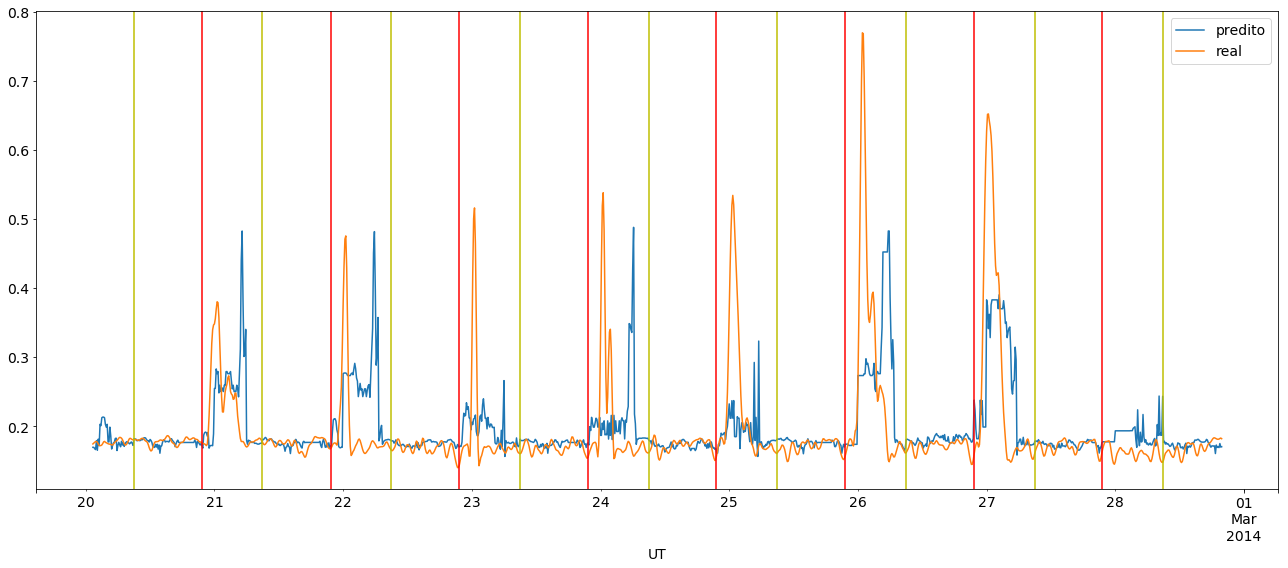

In [33]:
generate_and_avaliate_model(df, ['vtec',] + tempo + mdv2, 's4')

O erro quadrático médio foi: 0.000988
O erro quadrático total foi: 1.836382
O maior erro por previsão foi: 0.376678
O erro relativo foi: 6.090027%
O número de verdadeiros negativos foi: 2896
O número de verdadeiros positivos foi: 298
O número de falsos negativos foi: 77
O número de falsos positivos foi: 143
O POD foi: 0.794667
O FAR foi: 0.324263
A ACC foi: 0.935559
O kappa foi: 0.022788

Error for the time series sample:
O erro quadrático médio foi: 0.004706
O erro quadrático total foi: 2.438933
O maior erro por previsão foi: 0.442363
O erro relativo foi: 14.433141%
O número de verdadeiros negativos foi: 987
O número de verdadeiros positivos foi: 103
O número de falsos negativos foi: 50
O número de falsos positivos foi: 124
O POD foi: 0.673203
O FAR foi: 0.546256
A ACC foi: 0.862342
O kappa foi: 0.038882


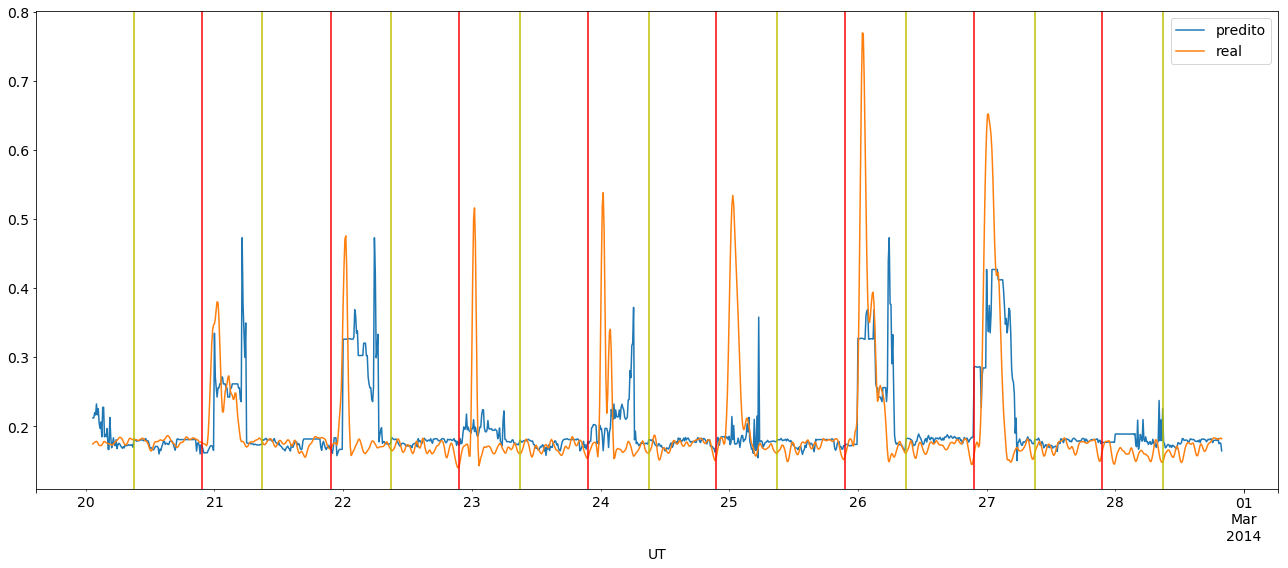

In [34]:
generate_and_avaliate_model(df, ['vtec',] + tempo + mdv1 + mdv2, 's4')

O erro quadrático médio foi: 0.001208
O erro quadrático total foi: 2.031169
O maior erro por previsão foi: 0.372049
O erro relativo foi: 7.953098%
O número de verdadeiros negativos foi: 2833
O número de verdadeiros positivos foi: 282
O número de falsos negativos foi: 93
O número de falsos positivos foi: 206
O POD foi: 0.752000
O FAR foi: 0.422131
A ACC foi: 0.912419
O kappa foi: 0.027589

Error for the time series sample:
O erro quadrático médio foi: 0.003609
O erro quadrático total foi: 2.135800
O maior erro por previsão foi: 0.468223
O erro relativo foi: 13.827686%
O número de verdadeiros negativos foi: 985
O número de verdadeiros positivos foi: 120
O número de falsos negativos foi: 33
O número de falsos positivos foi: 126
O POD foi: 0.784314
O FAR foi: 0.512195
A ACC foi: 0.874209
O kappa foi: 0.029809


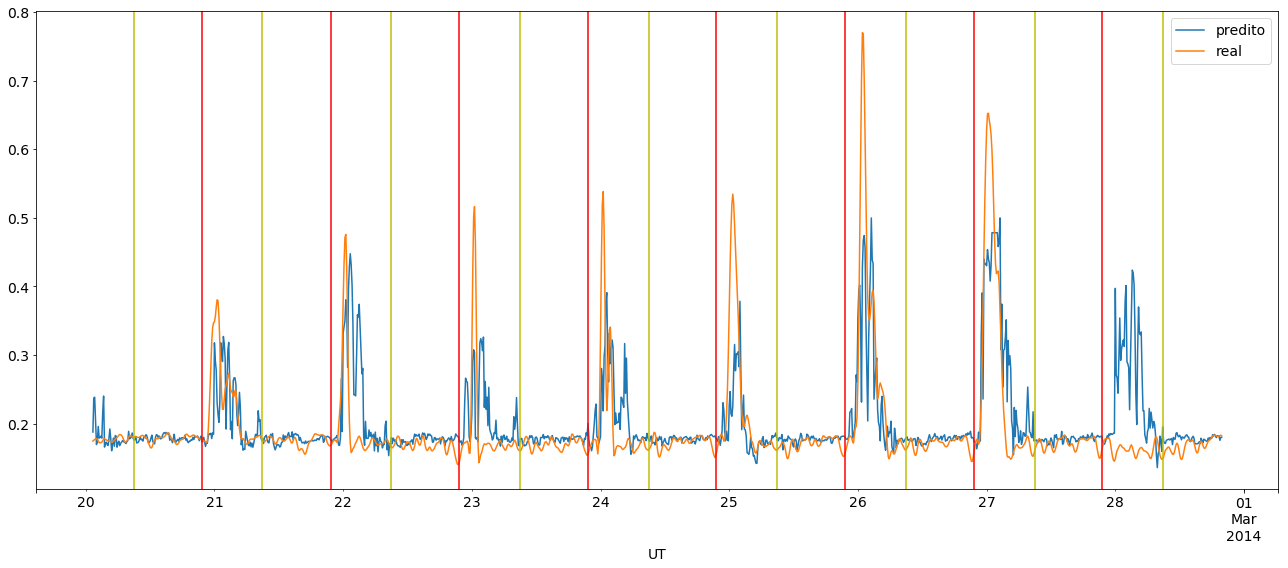

In [35]:
generate_and_avaliate_model(df, ['vtec',] + tempo + lag, 's4')

O erro quadrático médio foi: 0.000536
O erro quadrático total foi: 1.352852
O maior erro por previsão foi: 0.337299
O erro relativo foi: 5.161418%
O número de verdadeiros negativos foi: 2909
O número de verdadeiros positivos foi: 316
O número de falsos negativos foi: 59
O número de falsos positivos foi: 130
O POD foi: 0.842667
O FAR foi: 0.291480
A ACC foi: 0.944640
O kappa foi: 0.018250

Error for the time series sample:
O erro quadrático médio foi: 0.005879
O erro quadrático total foi: 2.725971
O maior erro por previsão foi: 0.591947
O erro relativo foi: 12.959668%
O número de verdadeiros negativos foi: 1021
O número de verdadeiros positivos foi: 87
O número de falsos negativos foi: 66
O número de falsos positivos foi: 90
O POD foi: 0.568627
O FAR foi: 0.508475
A ACC foi: 0.876582
O kappa foi: 0.047078


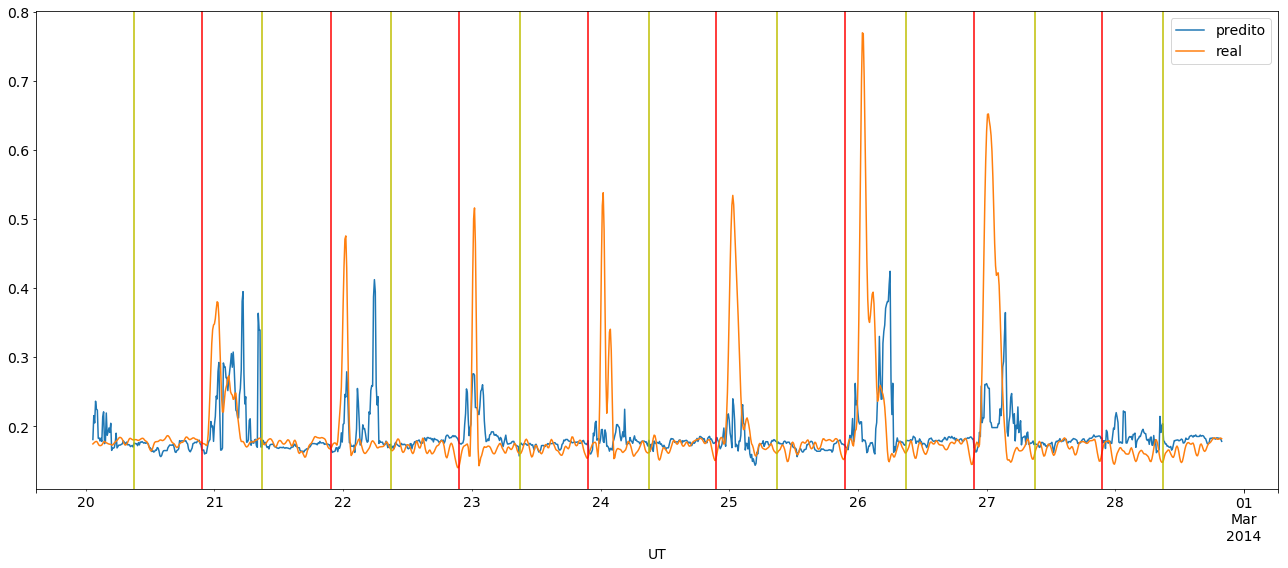

In [36]:
generate_and_avaliate_model(df, ['vtec',] + tempo + lag + mdv1, 's4')

O erro quadrático médio foi: 0.000567
O erro quadrático total foi: 1.391414
O maior erro por previsão foi: 0.351236
O erro relativo foi: 5.131166%
O número de verdadeiros negativos foi: 2906
O número de verdadeiros positivos foi: 326
O número de falsos negativos foi: 49
O número de falsos positivos foi: 133
O POD foi: 0.869333
O FAR foi: 0.289760
A ACC foi: 0.946690
O kappa foi: 0.015937

Error for the time series sample:
O erro quadrático médio foi: 0.004515
O erro quadrático total foi: 2.389043
O maior erro por previsão foi: 0.556499
O erro relativo foi: 12.578522%
O número de verdadeiros negativos foi: 990
O número de verdadeiros positivos foi: 112
O número de falsos negativos foi: 41
O número de falsos positivos foi: 121
O POD foi: 0.732026
O FAR foi: 0.519313
A ACC foi: 0.871835
O kappa foi: 0.033888


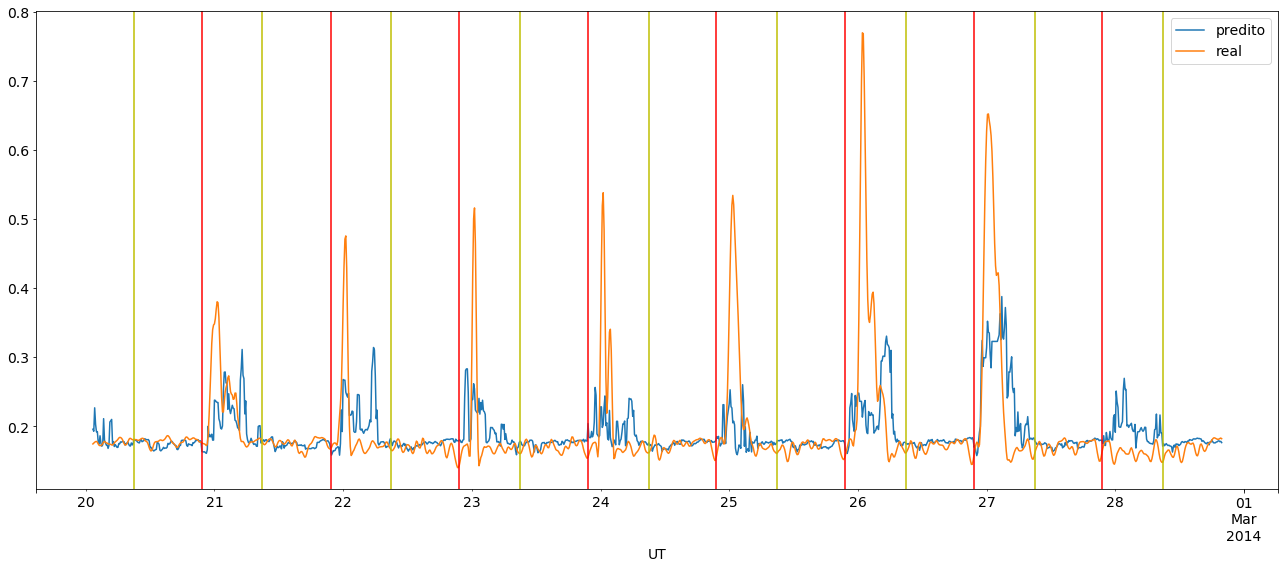

In [37]:
generate_and_avaliate_model(df, ['vtec',] + tempo + lag + mdv2, 's4')

O erro quadrático médio foi: 0.000614
O erro quadrático total foi: 1.448223
O maior erro por previsão foi: 0.355354
O erro relativo foi: 5.075592%
O número de verdadeiros negativos foi: 2904
O número de verdadeiros positivos foi: 320
O número de falsos negativos foi: 55
O número de falsos positivos foi: 135
O POD foi: 0.853333
O FAR foi: 0.296703
A ACC foi: 0.944347
O kappa foi: 0.017410

Error for the time series sample:
O erro quadrático médio foi: 0.005560
O erro quadrático total foi: 2.650891
O maior erro por previsão foi: 0.592578
O erro relativo foi: 12.998270%
O número de verdadeiros negativos foi: 1014
O número de verdadeiros positivos foi: 91
O número de falsos negativos foi: 62
O número de falsos positivos foi: 97
O POD foi: 0.594771
O FAR foi: 0.515957
A ACC foi: 0.874209
O kappa foi: 0.044874


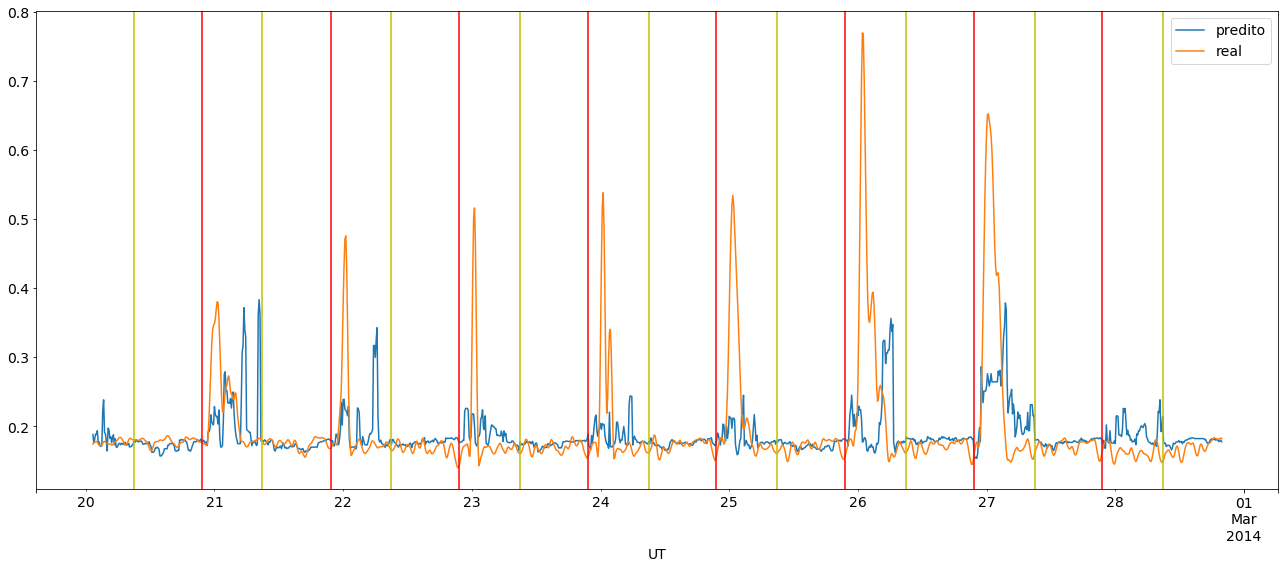

In [38]:
generate_and_avaliate_model(df, ['vtec',] + tempo + lag + mdv1 + mdv2, 's4')

O erro quadrático médio foi: 0.000619
O erro quadrático total foi: 1.453355
O maior erro por previsão foi: 0.303864
O erro relativo foi: 5.189917%
O número de verdadeiros negativos foi: 2891
O número de verdadeiros positivos foi: 333
O número de falsos negativos foi: 42
O número de falsos positivos foi: 148
O POD foi: 0.888000
O FAR foi: 0.307692
A ACC foi: 0.944347
O kappa foi: 0.014646

Error for the time series sample:
O erro quadrático médio foi: 0.003896
O erro quadrático total foi: 2.219220
O maior erro por previsão foi: 0.414328
O erro relativo foi: 13.784584%
O número de verdadeiros negativos foi: 937
O número de verdadeiros positivos foi: 115
O número de falsos negativos foi: 38
O número de falsos positivos foi: 174
O POD foi: 0.751634
O FAR foi: 0.602076
A ACC foi: 0.832278
O kappa foi: 0.034810


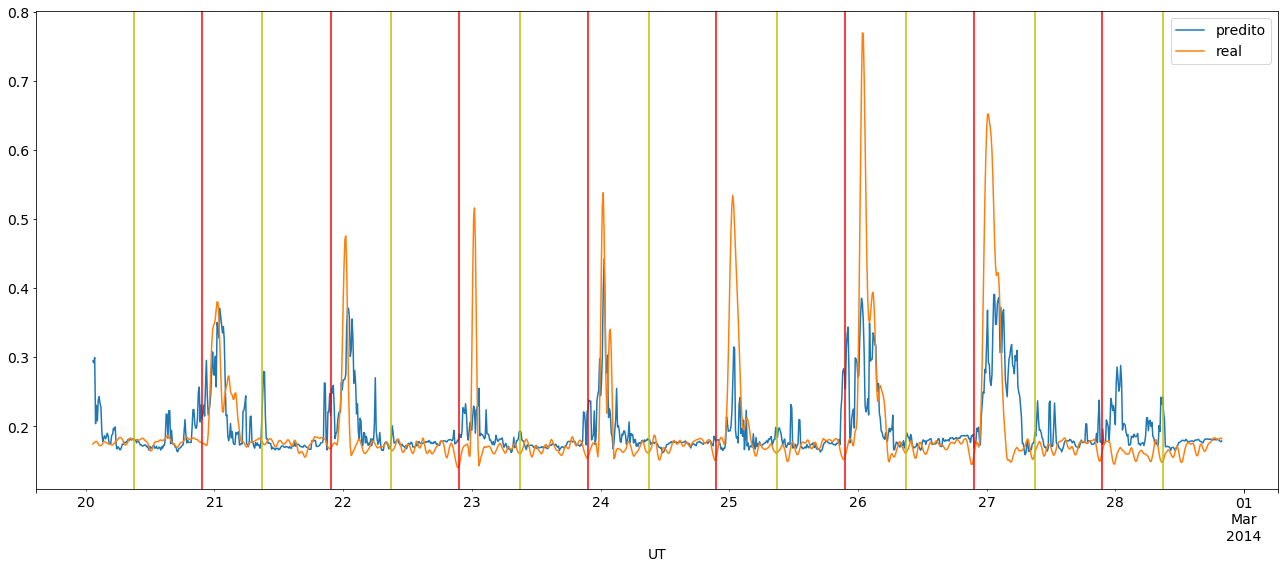

In [39]:
generate_and_avaliate_model(df, original + tempo + lag + mdv1 + mdv2, 's4')